In [1]:
import torch
import chimeralm
from chimeralm.data.tokenizer import load_tokenizer_from_hyena_model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [48]:
class AttentionVisualizer:
    def __init__(self):
        self.model = chimeralm.models.ChimeraLM.from_pretrained("yangliz5/chimeralm", save_attention=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.eval()
        self.model.to(self.device)
        self.tokenizer = load_tokenizer_from_hyena_model("hyenadna-small-32k-seqlen")

    def attention_weights(self, sequence):
        tokenized = self.tokenizer(sequence, truncation=True, padding=True, max_length=32768, return_tensors="pt")
        input_ids = tokenized["input_ids"].to(self.device)
        input_quals = None  # We don't have quality scores for web input
        with torch.no_grad():
            logits = self.model(input_ids, input_quals)
            probabilities = torch.softmax(logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities[0][predicted_class].item()

        confidence_breakdown = {
                "Biological": f"{probabilities[0][0].item():.3f}",
                "Chimeric Artifact": f"{probabilities[0][1].item():.3f}"}

        print(confidence_breakdown)
        
        # Check if attention weights exist and handle potential errors
        if not hasattr(self.model.net.head, 'attention_weights') or self.model.net.head.attention_weights is None:
            raise ValueError("Attention weights not available. Make sure the model was loaded with save_attention=True")
        
        # Get attention weights and convert to CPU/numpy for visualization
        attention_weights = self.model.net.head.attention_weights.squeeze(dim=(0, -1))
        if attention_weights.is_cuda:
            attention_weights = attention_weights.cpu()
        
        return probabilities, attention_weights

    def visualize(self, sequence, *args, **kwargs):
        import matplotlib.pyplot as plt

        # Get the attention weights for the last layer
        weights = self.attention_weights(sequence)[1]

        # Convert to numpy if it's a tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()

        # Remove special tokens (CLS token at the beginning)
        # The tokenizer adds [CLS] token at position 0, so we skip it
        weights = weights[1:]
        
        # Ensure we have the right number of weights for the sequence
        if len(weights) != len(sequence):
            print(f"Warning: Sequence length ({len(sequence)}) doesn't match attention weights length ({len(weights)})")
            # Take the minimum to avoid index errors
            min_len = min(len(weights), len(sequence))
            weights = weights[:min_len]
            sequence = sequence[:min_len]

        # Create the plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(sequence)), weights, 'b-', linewidth=2, marker='o', markersize=4, *args, **kwargs)
        plt.xticks(range(len(sequence)), list(sequence), fontsize=12)
        plt.xlabel('Sequence Position', fontsize=14)
        plt.ylabel('Attention Weight', fontsize=14)
        plt.title('Attention Weights Visualization', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return weights


    

In [4]:
sequence = "ATCGCGTG"

In [5]:
atten_vis = AttentionVisualizer()

config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

configuration_hyena.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- configuration_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hyena.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- modeling_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_hyena.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen-hf:
- tokenization_hyena.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


special_tokens_map.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

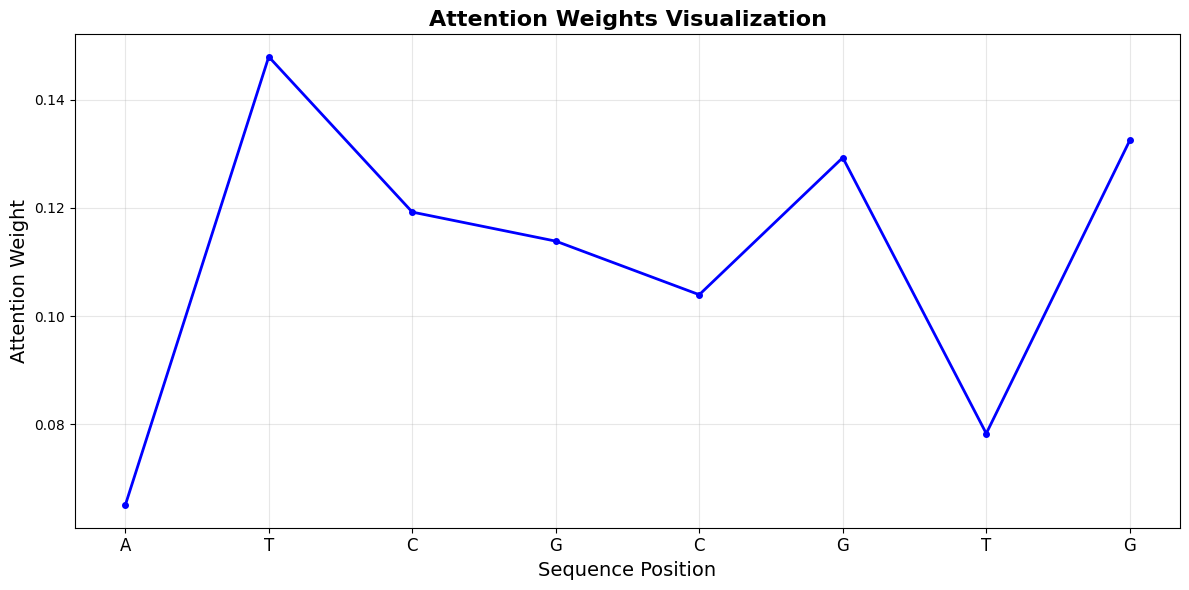

array([0.06500999, 0.14795601, 0.11923233, 0.11386099, 0.10395291,
       0.12930304, 0.07828572, 0.13249174], dtype=float32)

In [16]:
atten_vis.visualize(sequence)

In [7]:
# Additional utility methods for better attention visualization

class EnhancedAttentionVisualizer(AttentionVisualizer):
    """Enhanced version with additional visualization methods and error handling."""
    
    def get_tokenized_sequence(self, sequence):
        """Get tokenized sequence with special tokens for debugging."""
        tokenized = self.tokenizer(sequence, truncation=True, padding=True, max_length=32768, return_tensors="pt")
        input_ids = tokenized["input_ids"].squeeze(0)  # Remove batch dimension
        
        # Decode tokens to see what the model actually sees
        tokens = []
        for token_id in input_ids:
            token = self.tokenizer.decode([token_id])
            tokens.append(token)
        
        return tokens, input_ids
    
    def visualize_with_tokens(self, sequence):
        """Visualize attention weights showing actual tokens."""
        import matplotlib.pyplot as plt
        
        # Get tokenized representation
        tokens, input_ids = self.get_tokenized_sequence(sequence)
        
        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        
        # Convert to numpy if tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        
        # Remove CLS token (first token)
        tokens = tokens[1:]
        weights = weights[1:]
        
        # Create visualization
        plt.figure(figsize=(max(len(tokens) * 0.8, 10), 6))
        x_pos = range(len(tokens))
        
        # Plot bars for better visibility
        bars = plt.bar(x_pos, weights, alpha=0.7, color='steelblue', edgecolor='navy', linewidth=1)
        
        # Add value labels on bars
        for i, (bar, weight) in enumerate(zip(bars, weights)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'{weight:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.xticks(x_pos, tokens, fontsize=12, rotation=45 if len(tokens) > 10 else 0)
        plt.xlabel('Tokens', fontsize=14)
        plt.ylabel('Attention Weight', fontsize=14)
        plt.title(f'Attention Weights for Sequence: {sequence}', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        return weights, tokens
    
    def compare_sequences(self, sequences, labels=None):
        """Compare attention patterns across multiple sequences."""
        import matplotlib.pyplot as plt
        
        if labels is None:
            labels = [f"Seq {i+1}" for i in range(len(sequences))]
        
        fig, axes = plt.subplots(len(sequences), 1, figsize=(12, 4 * len(sequences)))
        if len(sequences) == 1:
            axes = [axes]
        
        for i, (seq, label) in enumerate(zip(sequences, labels)):
            try:
                weights = self.attention_weights(seq)[1]
                if torch.is_tensor(weights):
                    weights = weights.detach().numpy()
                
                weights = weights[1:]  # Remove CLS token
                
                axes[i].plot(range(len(seq)), weights, 'o-', linewidth=2, markersize=6)
                axes[i].set_xticks(range(len(seq)))
                axes[i].set_xticklabels(list(seq), fontsize=10)
                axes[i].set_ylabel('Attention Weight', fontsize=12)
                axes[i].set_title(f'{label}: {seq}', fontsize=14, fontweight='bold')
                axes[i].grid(True, alpha=0.3)
                
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', 
                           transform=axes[i].transAxes, fontsize=12, color='red')
        
        plt.xlabel('Sequence Position', fontsize=14)
        plt.tight_layout()
        plt.show()

# Test the enhanced visualizer
enhanced_vis = EnhancedAttentionVisualizer()


Testing enhanced attention visualization...

1. Testing original visualize method:


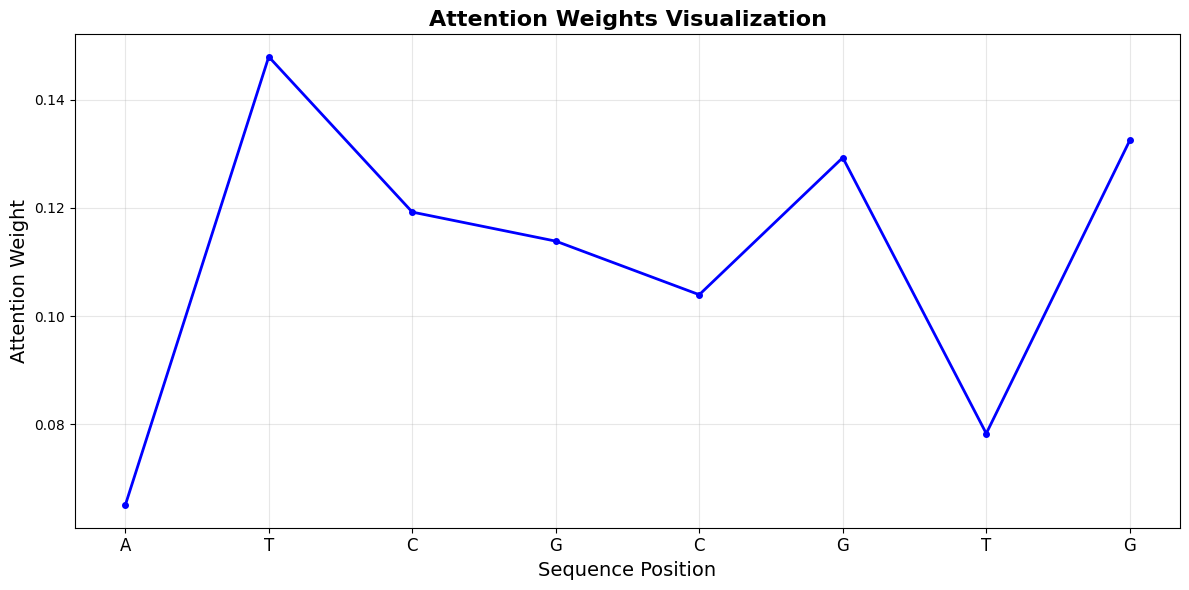


2. Testing visualize_with_tokens method:


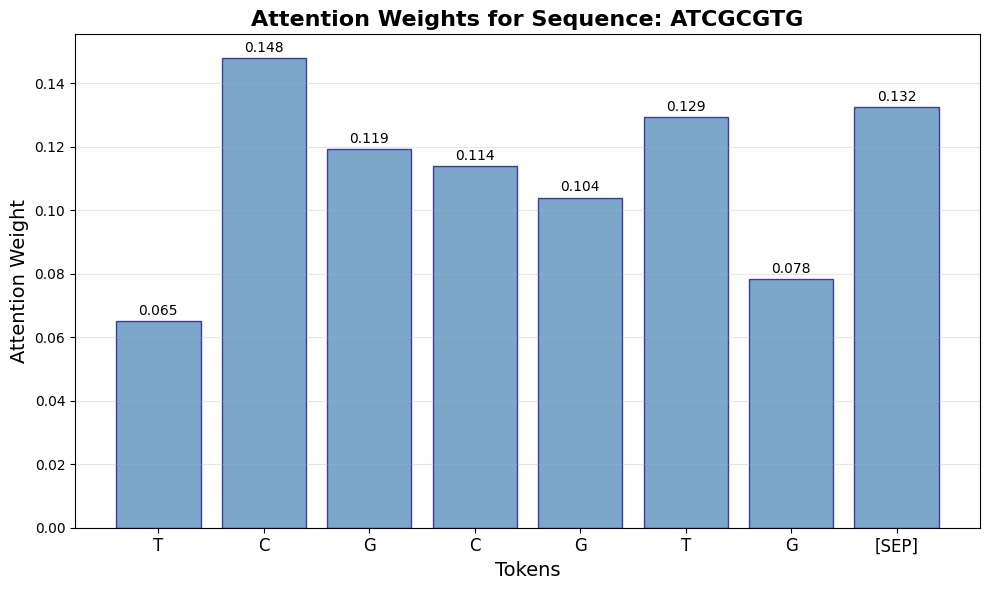

Tokens: ['T', 'C', 'G', 'C', 'G', 'T', 'G', '[SEP]']
Weights: [0.06500999 0.14795601 0.11923233 0.11386099 0.10395291 0.12930304
 0.07828572 0.13249174]

3. Testing compare_sequences method:


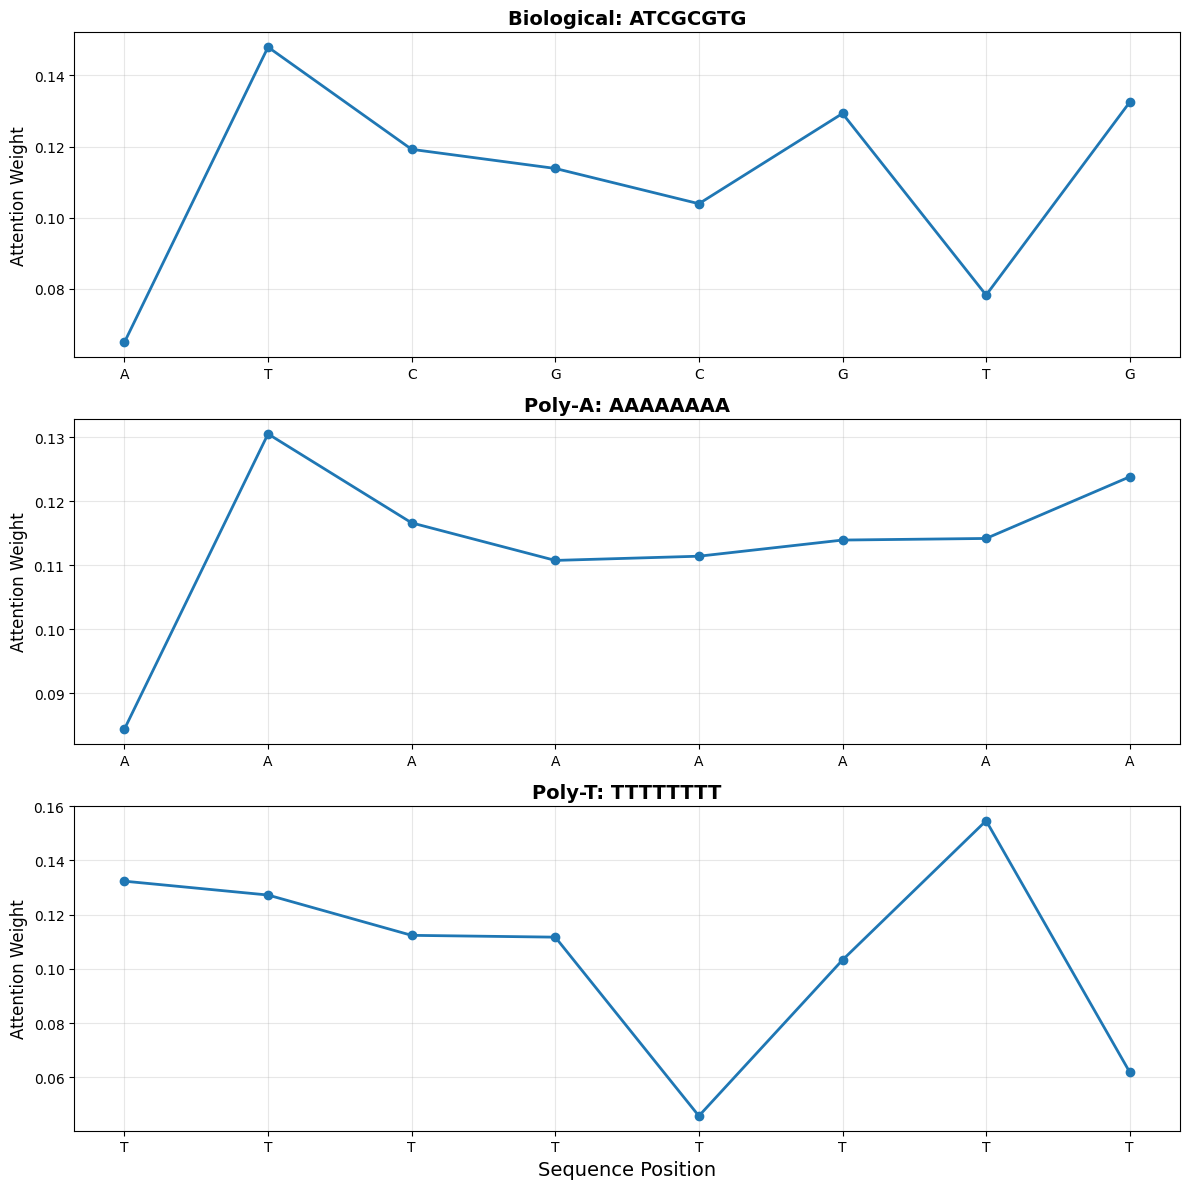

In [18]:
# Test the enhanced visualizer with better error handling
test_sequences = ["ATCGCGTG", "AAAAAAAA", "TTTTTTTT"]

print("Testing enhanced attention visualization...")
try:
    # Test the original method
    print("\n1. Testing original visualize method:")
    enhanced_vis.visualize(test_sequences[0])
    
    # Test the enhanced method with tokens
    print("\n2. Testing visualize_with_tokens method:")
    weights, tokens = enhanced_vis.visualize_with_tokens(test_sequences[0])
    print(f"Tokens: {tokens}")
    print(f"Weights: {weights}")
    
    # Test comparison method
    print("\n3. Testing compare_sequences method:")
    enhanced_vis.compare_sequences(test_sequences, ["Biological", "Poly-A", "Poly-T"])
    
except Exception as e:
    print(f"Error occurred: {e}")
    print("This might be due to attention weights not being available or model configuration issues.")


In [49]:
# Enhanced methods for handling LONG sequences (4k+ nucleotides)

class LongSequenceAttentionVisualizer(AttentionVisualizer):
    """Specialized visualizer for very long sequences (4k+ nucleotides)."""
    
    def visualize_long_sequence(self, sequence, max_display_length=200, window_size=50):
        """Visualize attention weights for very long sequences with windowing."""
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        
        # Convert to numpy if tensor
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        
        # Remove CLS token
        weights = weights[1:]
        
        seq_length = len(sequence)
        weights_length = len(weights)
        
        print(f"Sequence length: {seq_length}, Attention weights length: {weights_length}")
        
        # Handle length mismatch
        min_length = min(seq_length, weights_length)
        sequence = sequence[:min_length]
        weights = weights[:min_length]
        
        if min_length <= max_display_length:
            # Short sequence - show everything
            self._plot_full_sequence(sequence, weights)
        else:
            # Long sequence - use windowing approach
            self._plot_windowed_sequence(sequence, weights, window_size)
            
        return weights
    
    def _plot_full_sequence(self, sequence, weights):
        """Plot full sequence for shorter sequences."""
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(15, 6))
        
        # Line plot
        plt.subplot(2, 1, 1)
        plt.plot(range(len(sequence)), weights, 'b-', linewidth=1, alpha=0.7)
        plt.xlabel('Position')
        plt.ylabel('Attention Weight')
        plt.title(f'Attention Weights - Full Sequence (Length: {len(sequence)})')
        plt.grid(True, alpha=0.3)
        
        # Heatmap for better visualization
        plt.subplot(2, 1, 2)
        # Reshape weights for heatmap (create a 2D view)
        width = min(50, len(weights))
        height = (len(weights) + width - 1) // width
        weights_2d = np.pad(weights, (0, width * height - len(weights)), 'constant')
        weights_2d = weights_2d.reshape(height, width)
        
        plt.imshow(weights_2d, aspect='auto', cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Attention Weight')
        plt.xlabel('Position (mod 50)')
        plt.ylabel('Position // 50')
        plt.title('Attention Weights Heatmap')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_windowed_sequence(self, sequence, weights, window_size=50):
        """Plot long sequence using windowing approach."""
        import matplotlib.pyplot as plt
        
        seq_length = len(sequence)
        num_windows = (seq_length + window_size - 1) // window_size
        
        # Create subplots for different windows
        fig, axes = plt.subplots(min(num_windows, 4), 1, figsize=(15, 4 * min(num_windows, 4)))
        if num_windows == 1:
            axes = [axes]
        
        for i in range(min(num_windows, 4)):
            start_idx = i * window_size
            end_idx = min((i + 1) * window_size, seq_length)
            
            window_seq = sequence[start_idx:end_idx]
            window_weights = weights[start_idx:end_idx]
            
            axes[i].plot(range(len(window_seq)), window_weights, 'b-', linewidth=1, marker='o', markersize=2)
            axes[i].set_xlabel('Position within window')
            axes[i].set_ylabel('Attention Weight')
            axes[i].set_title(f'Window {i+1}: Positions {start_idx}-{end_idx-1}')
            axes[i].grid(True, alpha=0.3)
            
            # Add sequence labels for short windows
            if len(window_seq) <= 20:
                axes[i].set_xticks(range(len(window_seq)))
                axes[i].set_xticklabels(list(window_seq), fontsize=8, rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\nAttention Weight Statistics for {seq_length}-length sequence:")
        print(f"Mean: {np.mean(weights):.4f}")
        print(f"Std: {np.std(weights):.4f}")
        print(f"Min: {np.min(weights):.4f}")
        print(f"Max: {np.max(weights):.4f}")
        print(f"Top 10 highest attention positions: {np.argsort(weights)[-10:]}")
    
    def find_attention_peaks(self, sequence, top_k=10):
        """Find positions with highest attention weights."""
        weights = self.attention_weights(sequence)[1]
        
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        
        weights = weights[1:]  # Remove CLS token
        
        # Find top-k attention positions
        top_indices = np.argsort(weights)[-top_k:][::-1]
        
        print(f"Top {top_k} attention positions:")
        for i, idx in enumerate(top_indices):
            if idx < len(sequence):
                print(f"{i+1:2d}. Position {idx:4d}: '{sequence[idx]}' (weight: {weights[idx]:.4f})")
        
        return top_indices, weights[top_indices]
    
    def analyze_attention_patterns(self, sequence, pattern_length=10):
        """Analyze attention patterns in the sequence."""
        weights = self.attention_weights(sequence)[1]
        
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        
        weights = weights[1:]  # Remove CLS token
        
        # Find regions with high attention
        threshold = np.percentile(weights, 90)  # Top 10%
        high_attention_regions = []
        
        in_region = False
        region_start = 0
        
        for i, weight in enumerate(weights):
            if weight > threshold and not in_region:
                region_start = i
                in_region = True
            elif weight <= threshold and in_region:
                high_attention_regions.append((region_start, i-1))
                in_region = False
        
        if in_region:
            high_attention_regions.append((region_start, len(weights)-1))
        
        print(f"High attention regions (top 10% threshold: {threshold:.4f}):")
        for start, end in high_attention_regions:
            region_seq = sequence[start:end+1]
            avg_weight = np.mean(weights[start:end+1])
            print(f"  Position {start}-{end}: '{region_seq}' (avg weight: {avg_weight:.4f})")
        
        return high_attention_regions

# Create instance for testing
long_seq_vis = LongSequenceAttentionVisualizer()


Testing attention visualization with sequences of different lengths:
Short sequence (8 nt): ATCGCGTG
Medium sequence (200 nt): GTCTACGTCGGTGATCCGTGGACTAAGTTGTGCGCCGTGCGGACAACTGG...
Long sequence (1000 nt): GGAACGCCCCGTGCGTTACGTGGCTTTCGCGGACATCACTCAGTCAGAAG...
Very long sequence (4000 nt): TTAAGCTCTAGGTGCGGGGCGGCATGAAAGTAGGAAGTTGCGCTGTCCAC...

TESTING LONG SEQUENCE VISUALIZER

1. Testing medium sequence (200 nt):
Sequence length: 200, Attention weights length: 200


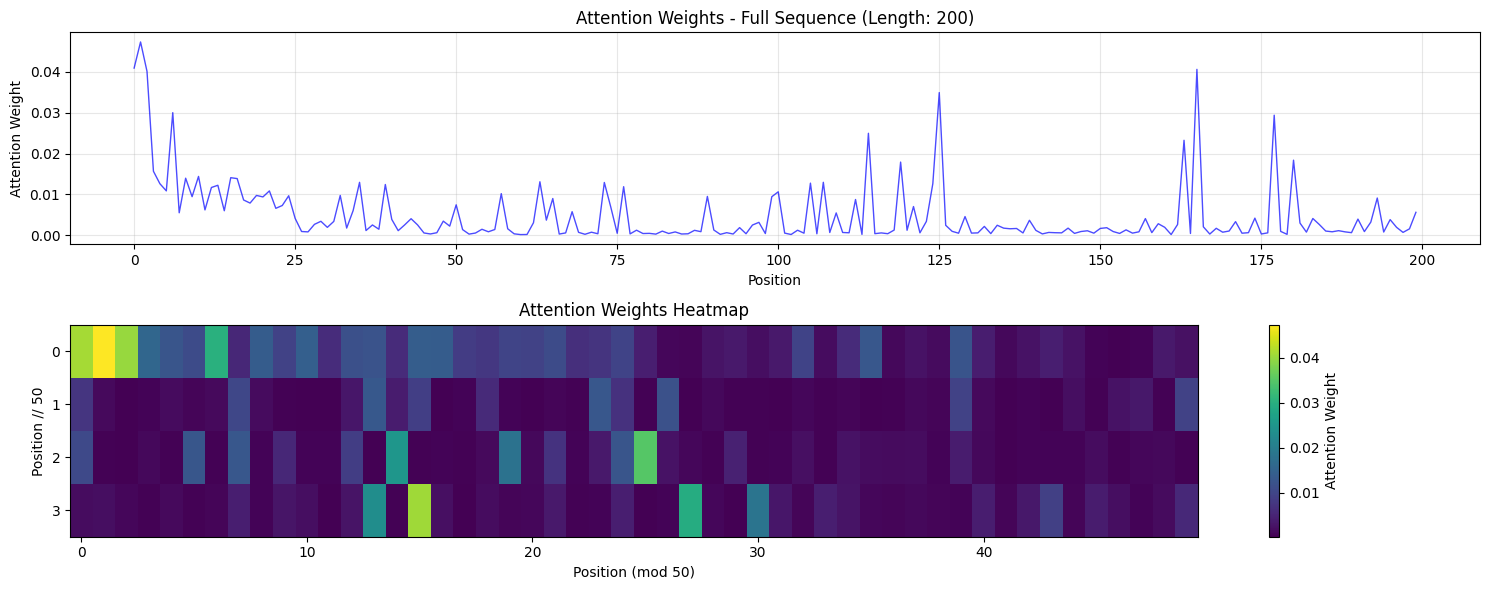


2. Finding attention peaks in medium sequence:
Top 5 attention positions:
 1. Position    1: 'T' (weight: 0.0473)
 2. Position    0: 'G' (weight: 0.0409)
 3. Position  165: 'C' (weight: 0.0406)
 4. Position    2: 'C' (weight: 0.0401)
 5. Position  125: 'C' (weight: 0.0349)

3. Analyzing attention patterns:
High attention regions (top 10% threshold: 0.0128):
  Position 0-3: 'GTCT' (avg weight: 0.0360)
  Position 6-6: 'G' (avg weight: 0.0300)
  Position 8-8: 'C' (avg weight: 0.0140)
  Position 10-10: 'G' (avg weight: 0.0144)
  Position 15-16: 'CC' (avg weight: 0.0140)
  Position 35-35: 'C' (avg weight: 0.0130)
  Position 63-63: 'C' (avg weight: 0.0131)
  Position 73-73: 'C' (avg weight: 0.0129)
  Position 107-107: 'A' (avg weight: 0.0130)
  Position 114-114: 'C' (avg weight: 0.0250)
  Position 119-119: 'C' (avg weight: 0.0179)
  Position 125-125: 'C' (avg weight: 0.0349)
  Position 163-163: 'C' (avg weight: 0.0233)
  Position 165-165: 'C' (avg weight: 0.0406)
  Position 177-177: 'C' (av

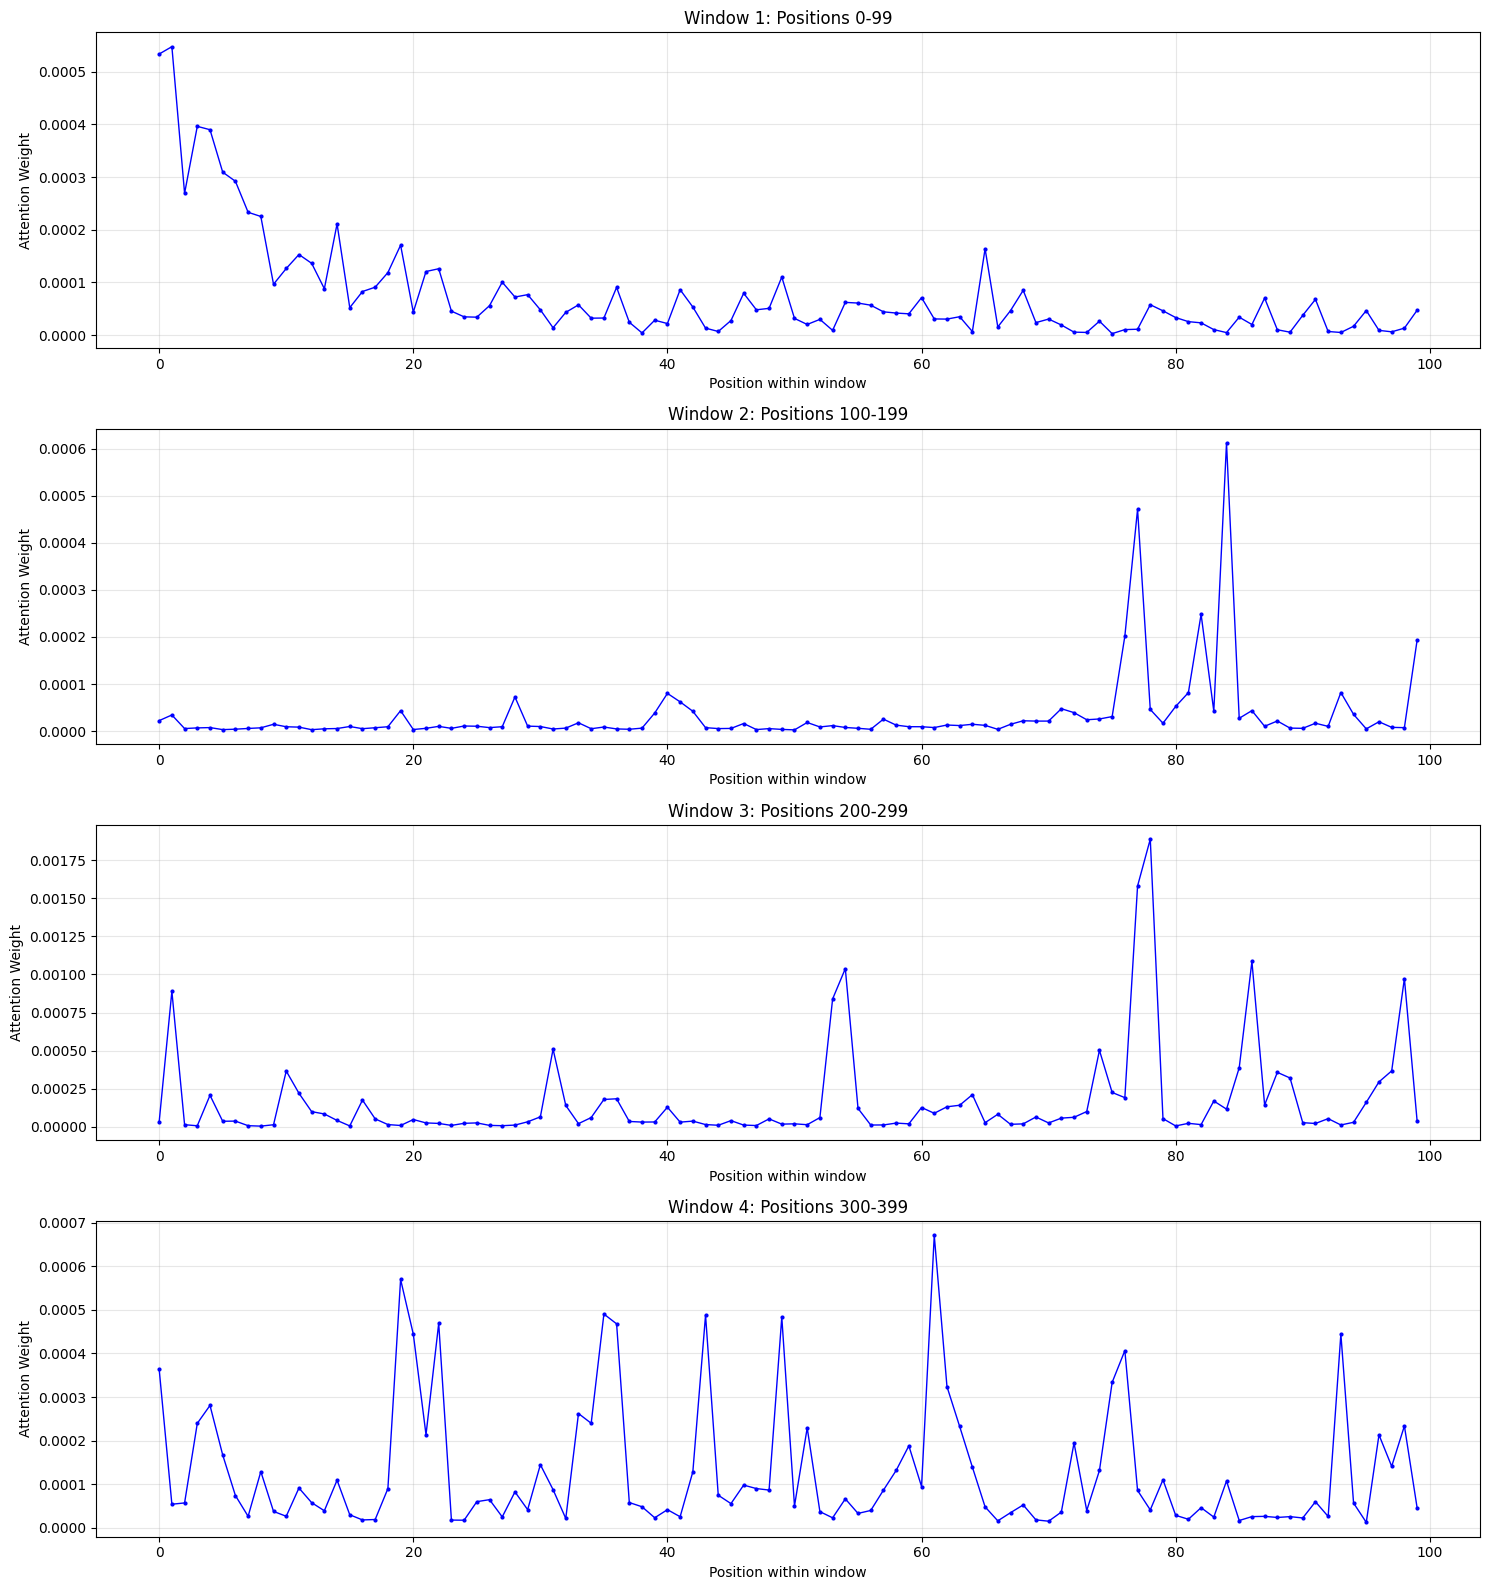


Attention Weight Statistics for 4000-length sequence:
Mean: 0.0002
Std: 0.0004
Min: 0.0000
Max: 0.0058
Top 10 highest attention positions: [2803 3158 2991  680 3344 3913  785 3979 3434 3938]

5. Finding attention peaks in very long sequence:
Top 10 attention positions:
 1. Position 3938: 'A' (weight: 0.0058)
 2. Position 3434: 'A' (weight: 0.0047)
 3. Position 3979: 'G' (weight: 0.0044)
 4. Position  785: 'C' (weight: 0.0044)
 5. Position 3913: 'A' (weight: 0.0044)
 6. Position 3344: 'A' (weight: 0.0042)
 7. Position  680: 'A' (weight: 0.0041)
 8. Position 2991: 'A' (weight: 0.0041)
 9. Position 3158: 'A' (weight: 0.0040)
10. Position 2803: 'A' (weight: 0.0039)


In [22]:
# Test with a very long sequence (simulating 4k nucleotides)
import random

def generate_long_sequence(length=4000):
    """Generate a random DNA sequence of specified length."""
    nucleotides = ['A', 'T', 'C', 'G']
    return ''.join(random.choices(nucleotides, k=length))

# Generate test sequences of different lengths
short_seq = "ATCGCGTG"  # Original test sequence
medium_seq = generate_long_sequence(200)  # Medium length
long_seq = generate_long_sequence(1000)   # Long sequence
very_long_seq = generate_long_sequence(4000)  # Very long sequence (4k)

print("Testing attention visualization with sequences of different lengths:")
print(f"Short sequence (8 nt): {short_seq}")
print(f"Medium sequence (200 nt): {medium_seq[:50]}...")
print(f"Long sequence (1000 nt): {long_seq[:50]}...")
print(f"Very long sequence (4000 nt): {very_long_seq[:50]}...")

# Test the long sequence visualizer
print("\n" + "="*60)
print("TESTING LONG SEQUENCE VISUALIZER")
print("="*60)

try:
    # Test with medium sequence first
    print("\n1. Testing medium sequence (200 nt):")
    long_seq_vis.visualize_long_sequence(medium_seq)
    
    # Test attention peaks
    print("\n2. Finding attention peaks in medium sequence:")
    peaks, peak_weights = long_seq_vis.find_attention_peaks(medium_seq, top_k=5)
    
    # Test pattern analysis
    print("\n3. Analyzing attention patterns:")
    regions = long_seq_vis.analyze_attention_patterns(medium_seq)
    
    # Test with very long sequence
    print("\n4. Testing very long sequence (4000 nt) - this may take a moment:")
    long_seq_vis.visualize_long_sequence(very_long_seq, window_size=100)
    
    print("\n5. Finding attention peaks in very long sequence:")
    peaks_long, peak_weights_long = long_seq_vis.find_attention_peaks(very_long_seq, top_k=10)
    
except Exception as e:
    print(f"Error occurred: {e}")
    print("This might be due to memory constraints or model limitations.")
    print("Try with shorter sequences first.")


In [50]:
# Focus on biologically meaningful positions

class BiologicalPositionAnalyzer(LongSequenceAttentionVisualizer):
    """Analyze attention patterns around specific biologically meaningful positions."""
    
    def analyze_position_of_interest(self, sequence, positions, window_size=50):
        """
        Analyze attention around specific biological positions.
        
        Args:
            sequence: DNA sequence
            positions: List of positions of interest (0-indexed)
            window_size: Size of window around each position to analyze
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[1:]  # Remove CLS token
        
        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)
        
        # Validate positions
        valid_positions = [pos for pos in positions if 0 <= pos < min_length]
        if len(valid_positions) != len(positions):
            print(f"Warning: Some positions are out of range. Valid positions: {valid_positions}")
        
        if not valid_positions:
            print("No valid positions to analyze!")
            return None
        
        # Calculate statistics
        overall_mean = np.mean(weights)
        overall_std = np.std(weights)
        
        print(f"Sequence length: {min_length}")
        print(f"Overall attention statistics:")
        print(f"  Mean: {overall_mean:.4f}")
        print(f"  Std: {overall_std:.4f}")
        print(f"  Min: {np.min(weights):.4f}")
        print(f"  Max: {np.max(weights):.4f}")
        
        # Analyze each position of interest
        position_stats = []
        for pos in valid_positions:
            # Define window around position
            start = max(0, pos - window_size // 2)
            end = min(min_length, pos + window_size // 2)
            
            window_weights = weights[start:end]
            window_mean = np.mean(window_weights)
            window_std = np.std(window_weights)
            
            # Calculate z-score (how many standard deviations from mean)
            z_score = (window_mean - overall_mean) / overall_std if overall_std > 0 else 0
            
            position_stats.append({
                'position': pos,
                'nucleotide': sequence[pos],
                'window_start': start,
                'window_end': end,
                'window_mean': window_mean,
                'window_std': window_std,
                'z_score': z_score,
                'relative_to_mean': window_mean / overall_mean if overall_mean > 0 else 0
            })
            
            print(f"\nPosition {pos} ('{sequence[pos]}'):")
            print(f"  Window [{start}:{end}]: {window_mean:.4f} ± {window_std:.4f}")
            print(f"  Z-score: {z_score:.2f} (higher than {((1 + np.sign(z_score))/2 * 100):.1f}% of sequence)")
            print(f"  Relative to mean: {position_stats[-1]['relative_to_mean']:.2f}x")
        
        return position_stats
    
    def visualize_position_comparison(self, sequence, positions, window_size=50, context_size=200):
        """Visualize attention around specific positions with context."""
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[1:]  # Remove CLS token
        
        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)
        
        # Validate positions
        valid_positions = [pos for pos in positions if 0 <= pos < min_length]
        
        if not valid_positions:
            print("No valid positions to visualize!")
            return
        
        # Create visualization
        fig, axes = plt.subplots(len(valid_positions) + 1, 1, figsize=(15, 4 * (len(valid_positions) + 1)))
        if len(valid_positions) == 0:
            axes = [axes]
        
        # Overall sequence view
        axes[0].plot(range(min_length), weights, 'b-', linewidth=0.5, alpha=0.7)
        axes[0].axhline(y=np.mean(weights), color='r', linestyle='--', alpha=0.7, label='Overall Mean')
        
        # Mark positions of interest
        for i, pos in enumerate(valid_positions):
            axes[0].axvline(x=pos, color='red', linestyle='-', linewidth=2, alpha=0.8)
            axes[0].text(pos, np.max(weights) * 0.9, f'P{i+1}', ha='center', va='bottom', 
                        fontsize=10, fontweight='bold', color='red')
        
        axes[0].set_title(f'Full Sequence Attention Pattern (Length: {min_length})', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Attention Weight')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Detailed views for each position
        for i, pos in enumerate(valid_positions):
            # Define context window
            start = max(0, pos - context_size // 2)
            end = min(min_length, pos + context_size // 2)
            
            window_weights = weights[start:end]
            window_positions = range(start, end)
            
            axes[i+1].plot(window_positions, window_weights, 'b-', linewidth=1, marker='o', markersize=2)
            axes[i+1].axvline(x=pos, color='red', linestyle='-', linewidth=3, alpha=0.8, label=f'Position {pos}')
            axes[i+1].axhline(y=np.mean(weights), color='r', linestyle='--', alpha=0.7, label='Overall Mean')
            axes[i+1].axhline(y=np.mean(window_weights), color='orange', linestyle=':', alpha=0.7, label='Local Mean')
            
            # Highlight the analysis window
            analysis_start = max(start, pos - window_size // 2)
            analysis_end = min(end, pos + window_size // 2)
            axes[i+1].axvspan(analysis_start, analysis_end, alpha=0.2, color='yellow', label='Analysis Window')
            
            axes[i+1].set_title(f'Position {pos} ("{sequence[pos]}") - Context Window', fontsize=12, fontweight='bold')
            axes[i+1].set_xlabel('Sequence Position')
            axes[i+1].set_ylabel('Attention Weight')
            axes[i+1].legend()
            axes[i+1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_biological_regions(self, sequence, region_definitions):
        """
        Compare attention between different biological regions.
        
        Args:
            sequence: DNA sequence
            region_definitions: Dict with region names and (start, end) tuples
                e.g., {'promoter': (100, 200), 'coding': (500, 1500), 'terminator': (1800, 2000)}
        """
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Get attention weights
        weights = self.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[1:]  # Remove CLS token
        
        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)
        
        # Analyze each region
        region_stats = {}
        for region_name, (start, end) in region_definitions.items():
            # Validate and clip region boundaries
            start = max(0, min(start, min_length))
            end = max(start, min(end, min_length))
            
            if start >= end:
                print(f"Warning: Invalid region {region_name} [{start}, {end}]")
                continue
            
            region_weights = weights[start:end]
            region_stats[region_name] = {
                'start': start,
                'end': end,
                'length': end - start,
                'mean': np.mean(region_weights),
                'std': np.std(region_weights),
                'median': np.median(region_weights),
                'max': np.max(region_weights),
                'min': np.min(region_weights),
                'weights': region_weights
            }
        
        # Print comparison
        print("Biological Region Attention Comparison:")
        print("=" * 60)
        
        overall_mean = np.mean(weights)
        overall_std = np.std(weights)
        
        for region_name, stats in region_stats.items():
            z_score = (stats['mean'] - overall_mean) / overall_std if overall_std > 0 else 0
            relative = stats['mean'] / overall_mean if overall_mean > 0 else 0
            
            print(f"\n{region_name.upper()} [{stats['start']}-{stats['end']}] (length: {stats['length']}):")
            print(f"  Mean attention: {stats['mean']:.4f} (z-score: {z_score:.2f})")
            print(f"  Relative to overall: {relative:.2f}x")
            print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
            print(f"  Std: {stats['std']:.4f}")
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Full sequence with regions highlighted
        ax1.plot(range(min_length), weights, 'b-', linewidth=0.5, alpha=0.7)
        ax1.axhline(y=overall_mean, color='r', linestyle='--', alpha=0.7, label='Overall Mean')
        
        colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
        for i, (region_name, stats) in enumerate(region_stats.items()):
            color = colors[i % len(colors)]
            ax1.axvspan(stats['start'], stats['end'], alpha=0.3, color=color, label=region_name)
            ax1.text((stats['start'] + stats['end']) / 2, np.max(weights) * 0.9, 
                    region_name, ha='center', va='bottom', fontweight='bold', color=color)
        
        ax1.set_title('Sequence with Biological Regions Highlighted', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Attention Weight')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plot comparison
        region_data = [stats['weights'] for stats in region_stats.values()]
        region_names = list(region_stats.keys())
        
        bp = ax2.boxplot(region_data, labels=region_names, patch_artist=True)
        ax2.axhline(y=overall_mean, color='r', linestyle='--', alpha=0.7, label='Overall Mean')
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax2.set_title('Attention Distribution by Biological Region', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Attention Weight')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return region_stats

# Create instance for biological analysis
bio_analyzer = BiologicalPositionAnalyzer()


BIOLOGICAL POSITION ATTENTION ANALYSIS
Test sequence length: 2000
Analyzing positions: [1200, 500, 1500, 1800]
Sequence preview: CTGACGGCATTCCCTCAACATTGCAAGTAACGTCCCTAAATCCAAAGTGCTATCAACGCGCCCATCTTCTTCCTGAACATTGGAGGTCCCTGACGGGCCG...

1. POSITION ANALYSIS
Sequence length: 2000
Overall attention statistics:
  Mean: 0.0005
  Std: 0.0006
  Min: 0.0000
  Max: 0.0049

Position 1200 ('C'):
  Window [1150:1250]: 0.0007 ± 0.0009
  Z-score: 0.34 (higher than 100.0% of sequence)
  Relative to mean: 1.44x

Position 500 ('T'):
  Window [450:550]: 0.0001 ± 0.0001
  Z-score: -0.63 (higher than 0.0% of sequence)
  Relative to mean: 0.18x

Position 1500 ('A'):
  Window [1450:1550]: 0.0005 ± 0.0005
  Z-score: -0.04 (higher than 0.0% of sequence)
  Relative to mean: 0.95x

Position 1800 ('A'):
  Window [1750:1850]: 0.0003 ± 0.0004
  Z-score: -0.33 (higher than 0.0% of sequence)
  Relative to mean: 0.58x

2. POSITION VISUALIZATION


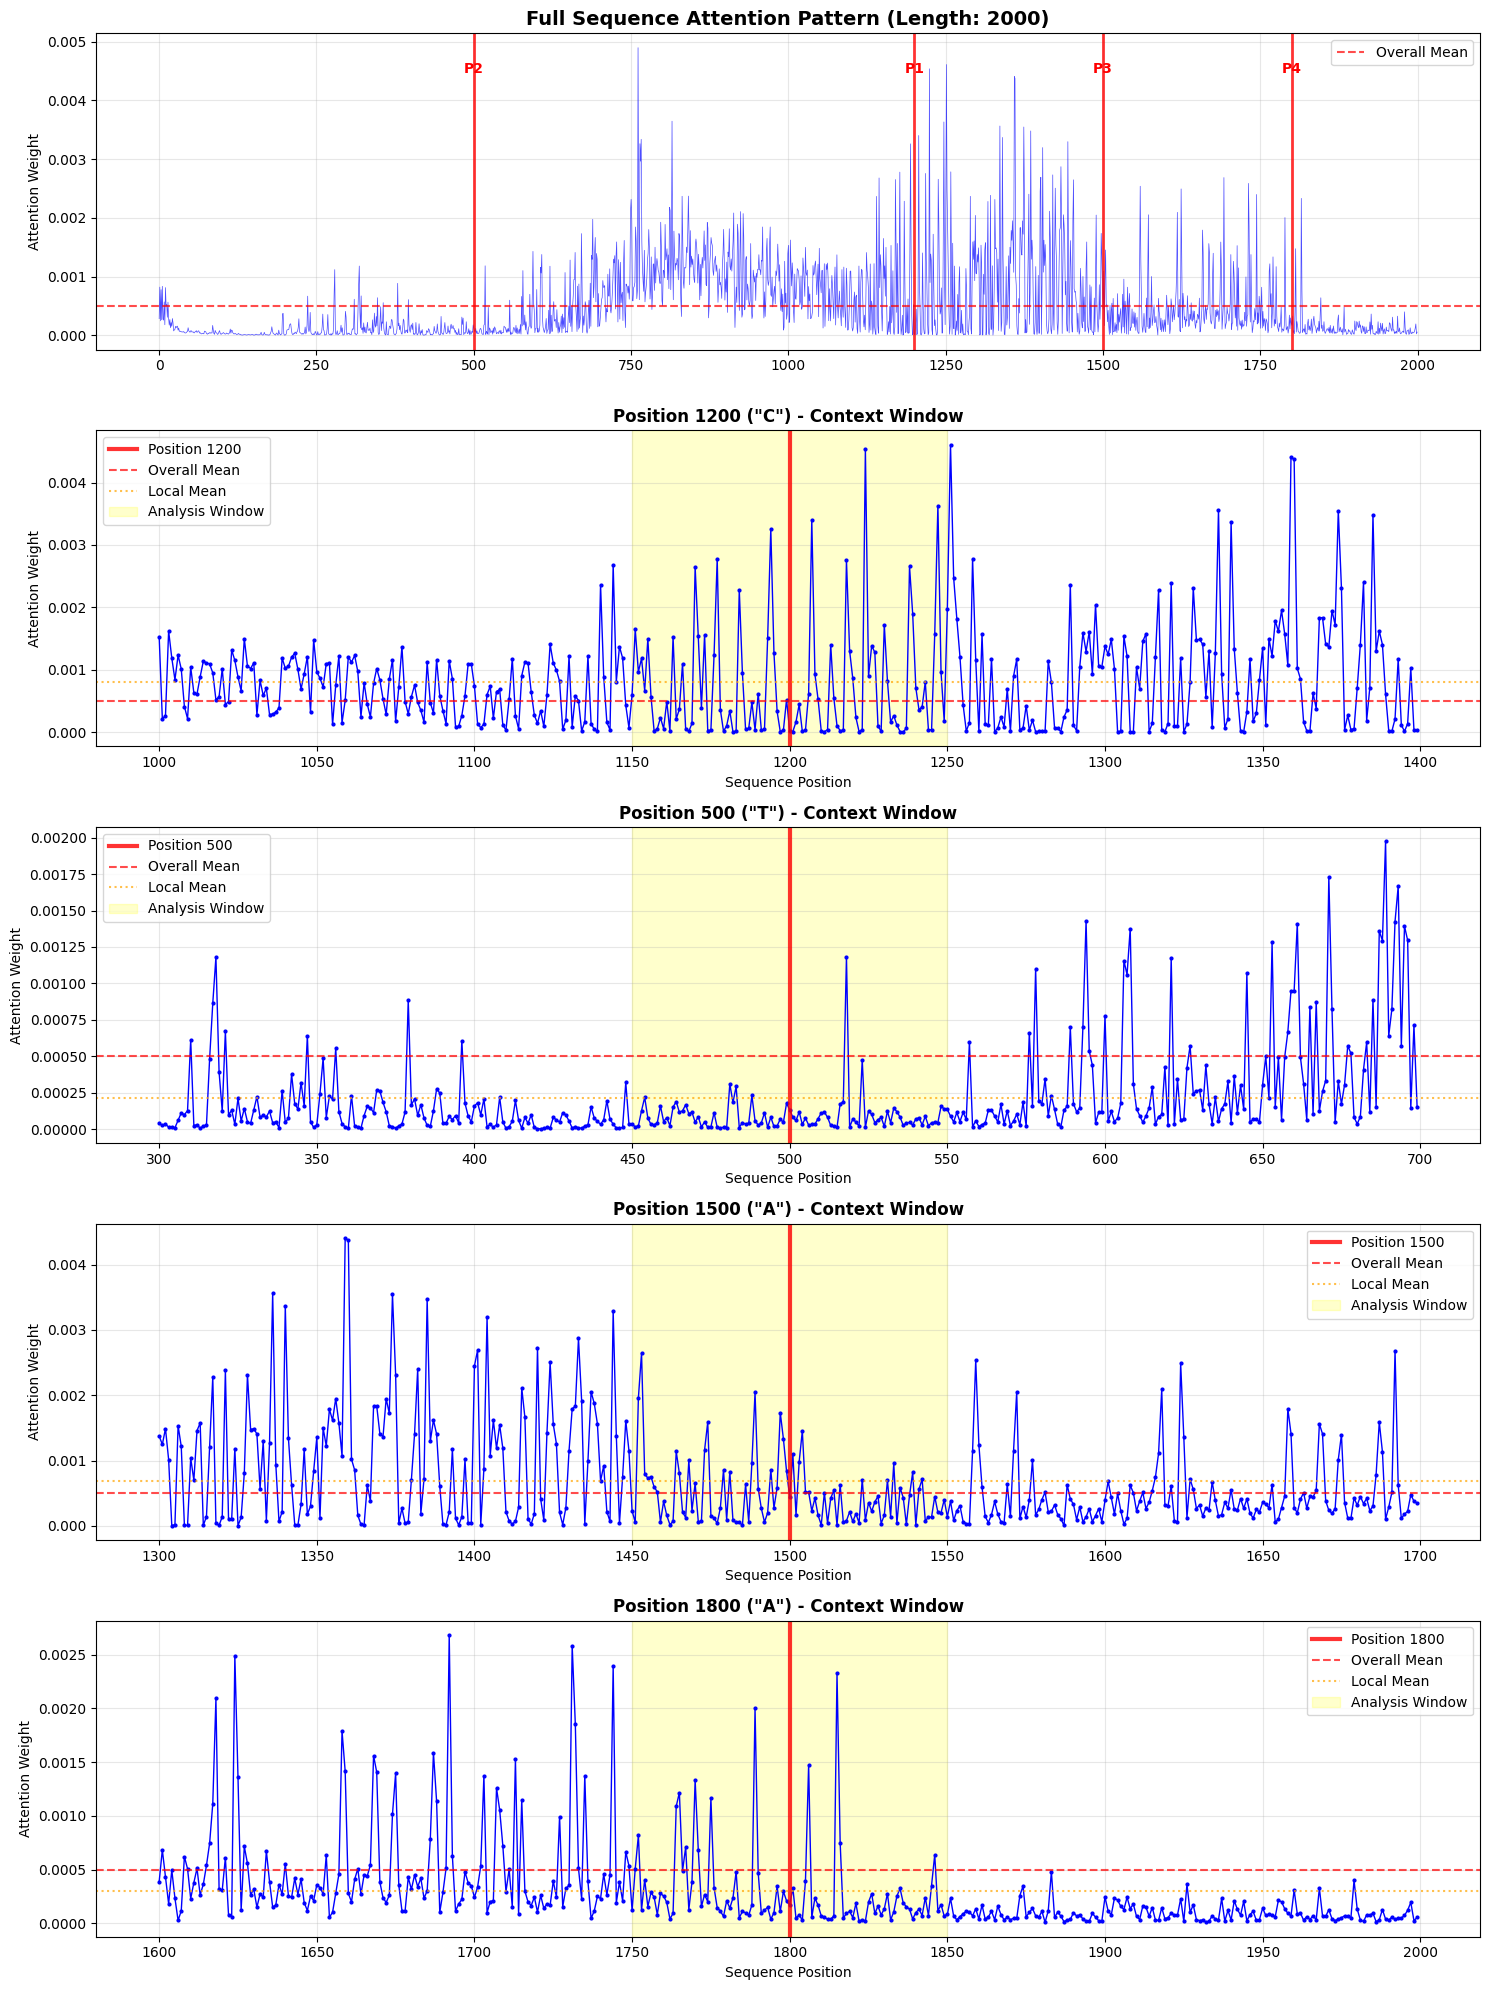


3. BIOLOGICAL REGION COMPARISON
Biological Region Attention Comparison:

UPSTREAM [0-400] (length: 400):
  Mean attention: 0.0001 (z-score: -0.61)
  Relative to overall: 0.21x
  Range: [0.0000, 0.0012]
  Std: 0.0002

PROMOTER [400-600] (length: 200):
  Mean attention: 0.0001 (z-score: -0.60)
  Relative to overall: 0.23x
  Range: [0.0000, 0.0014]
  Std: 0.0002

CODING_START [600-800] (length: 200):
  Mean attention: 0.0008 (z-score: 0.39)
  Relative to overall: 1.51x
  Range: [0.0000, 0.0049]
  Std: 0.0007

MIDDLE_CODING [800-1200] (length: 400):
  Mean attention: 0.0009 (z-score: 0.63)
  Relative to overall: 1.81x
  Range: [0.0000, 0.0036]
  Std: 0.0006

POSITION_OF_INTEREST [1150-1250] (length: 100):
  Mean attention: 0.0007 (z-score: 0.34)
  Relative to overall: 1.44x
  Range: [0.0000, 0.0045]
  Std: 0.0009

END_CODING [1200-1400] (length: 200):
  Mean attention: 0.0009 (z-score: 0.61)
  Relative to overall: 1.79x
  Range: [0.0000, 0.0046]
  Std: 0.0010

TERMINATOR [1400-1600] (leng

/var/folders/s3/vs6nrrg52sdfjk3z90p7ndt94gg4tq/T/ipykernel_36445/2009332791.py:236: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(region_data, labels=region_names, patch_artist=True)


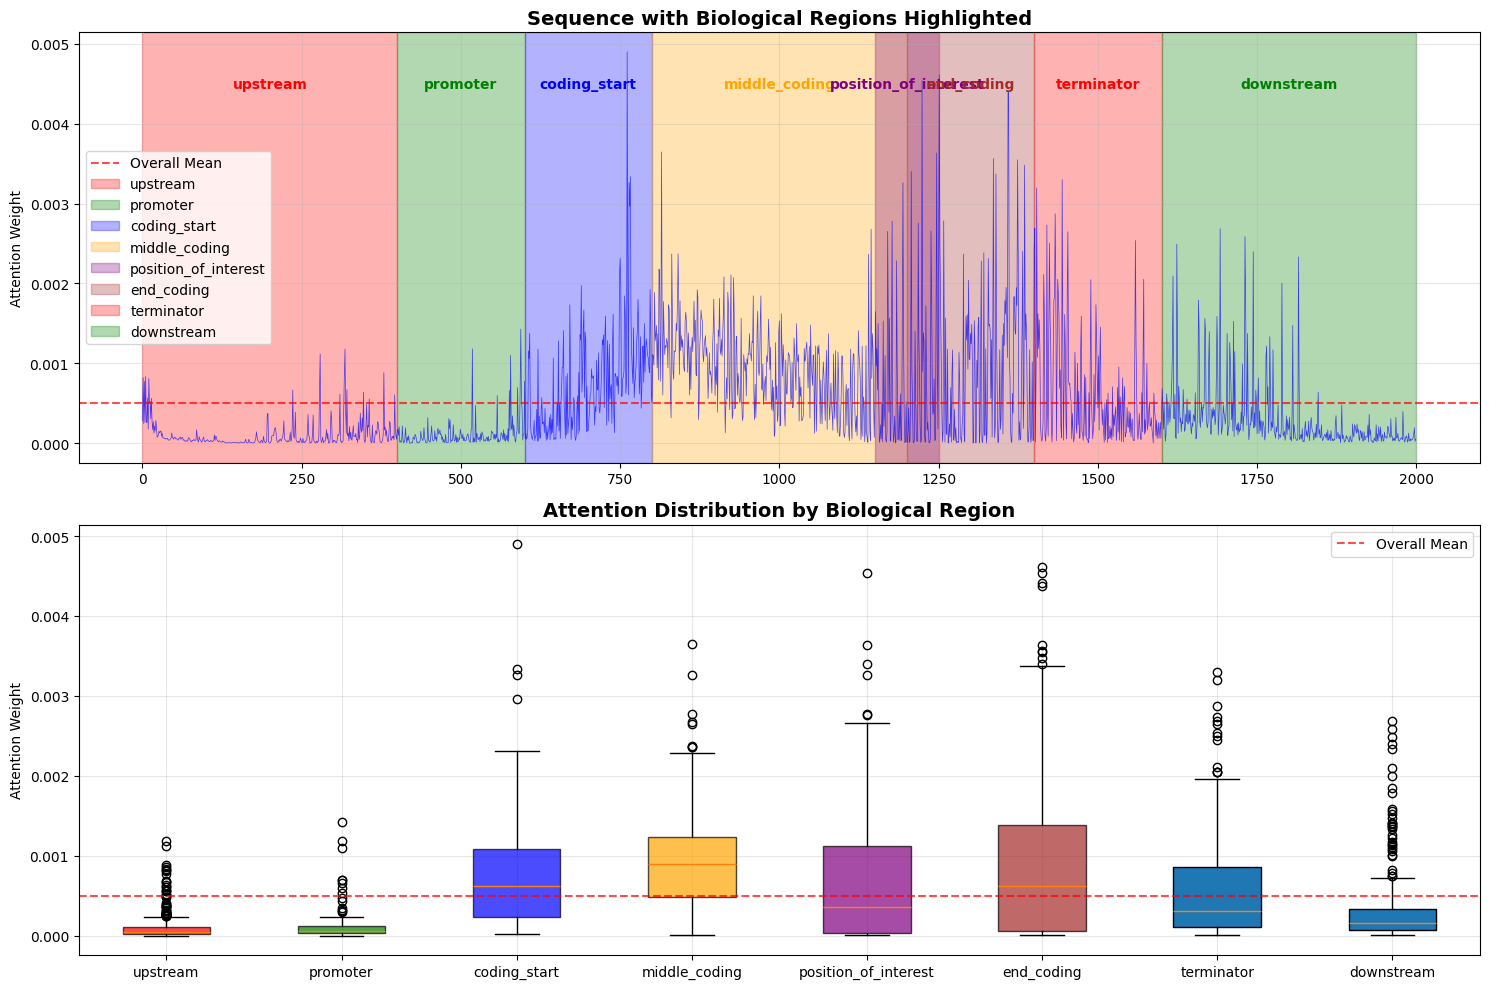


4. SUMMARY OF FINDINGS
Position Analysis Summary:
  Position 1200 (C):
    - Attention level: 1.44x the sequence average
    - Z-score: 0.34 (above 100.0% of sequence)
    - ⬆️  HIGHER attention than average
  Position 500 (T):
    - Attention level: 0.18x the sequence average
    - Z-score: -0.63 (above 0.0% of sequence)
    - ⬇️  LOWER attention than average
  Position 1500 (A):
    - Attention level: 0.95x the sequence average
    - Z-score: -0.04 (above 0.0% of sequence)
    - ➡️  SIMILAR attention to average
  Position 1800 (A):
    - Attention level: 0.58x the sequence average
    - Z-score: -0.33 (above 0.0% of sequence)
    - ⬇️  LOWER attention than average

5. TOP ATTENTION POSITIONS FOR COMPARISON
Top 10 attention positions:
 1. Position  761: 'G' (weight: 0.0049)
 2. Position 1251: 'A' (weight: 0.0046)
 3. Position 1224: 'G' (weight: 0.0045)
 4. Position 1359: 'A' (weight: 0.0044)
 5. Position 1360: 'A' (weight: 0.0044)
 6. Position  815: 'A' (weight: 0.0036)
 7. Position 

In [24]:
# Test biological position analysis
print("=" * 80)
print("BIOLOGICAL POSITION ATTENTION ANALYSIS")
print("=" * 80)

# Generate a longer test sequence (2000 nucleotides)
test_sequence = generate_long_sequence(2000)

# Define some biologically meaningful positions (e.g., start codon, regulatory sites, etc.)
biological_positions = [
    1200,  # Position of interest as mentioned in the question
    500,   # Another interesting position
    1500,  # Third position
    1800,  # Fourth position
]

print(f"Test sequence length: {len(test_sequence)}")
print(f"Analyzing positions: {biological_positions}")
print(f"Sequence preview: {test_sequence[:100]}...")

try:
    # 1. Analyze specific positions of interest
    print("\n" + "="*60)
    print("1. POSITION ANALYSIS")
    print("="*60)
    
    position_stats = bio_analyzer.analyze_position_of_interest(
        test_sequence, 
        biological_positions, 
        window_size=100  # Analyze ±50 nucleotides around each position
    )
    
    # 2. Visualize position comparison
    print("\n" + "="*60)
    print("2. POSITION VISUALIZATION")
    print("="*60)
    
    bio_analyzer.visualize_position_comparison(
        test_sequence, 
        biological_positions,
        window_size=100,      # Analysis window
        context_size=400      # Visualization context
    )
    
    # 3. Compare biological regions
    print("\n" + "="*60)
    print("3. BIOLOGICAL REGION COMPARISON")
    print("="*60)
    
    # Define different biological regions
    region_definitions = {
        'upstream': (0, 400),
        'promoter': (400, 600), 
        'coding_start': (600, 800),
        'middle_coding': (800, 1200),
        'position_of_interest': (1150, 1250),  # Around position 1200
        'end_coding': (1200, 1400),
        'terminator': (1400, 1600),
        'downstream': (1600, 2000)
    }
    
    region_stats = bio_analyzer.compare_biological_regions(test_sequence, region_definitions)
    
    # 4. Summary of findings
    print("\n" + "="*60)
    print("4. SUMMARY OF FINDINGS")
    print("="*60)
    
    if position_stats:
        print("Position Analysis Summary:")
        for i, stats in enumerate(position_stats):
            print(f"  Position {stats['position']} ({stats['nucleotide']}):")
            print(f"    - Attention level: {stats['relative_to_mean']:.2f}x the sequence average")
            print(f"    - Z-score: {stats['z_score']:.2f} (above {((1 + np.sign(stats['z_score']))/2 * 100):.1f}% of sequence)")
            if stats['relative_to_mean'] > 1.2:
                print(f"    - ⬆️  HIGHER attention than average")
            elif stats['relative_to_mean'] < 0.8:
                print(f"    - ⬇️  LOWER attention than average")
            else:
                print(f"    - ➡️  SIMILAR attention to average")
    
    # 5. Find highest attention positions for comparison
    print("\n" + "="*60)
    print("5. TOP ATTENTION POSITIONS FOR COMPARISON")
    print("="*60)
    
    peaks, peak_weights = bio_analyzer.find_attention_peaks(test_sequence, top_k=10)
    
    # Check if any of our biological positions are in the top attention positions
    biological_peaks = [pos for pos in biological_positions if pos in peaks[:10]]
    if biological_peaks:
        print(f"🎯 Biological positions in top 10 attention: {biological_peaks}")
    else:
        print("ℹ️  None of the biological positions are in the top 10 attention positions")
        print("   This suggests they may have average or lower attention levels.")

except Exception as e:
    print(f"Error occurred: {e}")
    print("This might be due to model limitations or memory constraints.")
    print("Try with shorter sequences first.")


# Analysis

In [10]:
from pathlib import Path

def chimeric_read_iterator(bam_path: Path):
    import pysam
    bam = pysam.AlignmentFile(bam_path)

    for read in bam.fetch():
        if chimeralm.data.bam.is_chimeric(read):
            yield read

In [11]:
bam_file = Path("/gpfs/projects/b1171/ylk4626/project/Chimera/data/raw/PC3_10_cells_MDA_Mk1c_dirty.bam")

In [12]:
chimeric_reads = chimeric_read_iterator(bam_file)

In [14]:
r1 = next(chimeric_reads)

In [33]:
r1.get_tag("SA")

'chr12,12767,-,460S249M2D30S,1,2;'

In [29]:
r1.query_alignment_start

272

In [30]:
r1.query_alignment_end

739

In [31]:
r1.query_alignment_end - r1.query_alignment_start

467

In [32]:
r1.query_length

739

In [24]:
len(r1.query_sequence)

739

In [25]:
r1.reference_start

11704

In [26]:
r1.reference_end

12169

In [27]:
r1.reference_end -  r1.reference_start

465

In [38]:
r1.query_name

'02cfd724-0744-4bb3-aed5-d7e41caf4493'

In [41]:
def get_sequence_and_pos(read):
    return read.query_name, read.query_sequence, [read.query_alignment_start, read.query_alignment_end-1]

In [42]:
read_name, test_sequence, biological_positions = get_sequence_and_pos(r1)

In [51]:
def show_attention_with_biological_pos(read):
    read_name, test_sequence, biological_positions = get_sequence_and_pos(read)

    print(f"{read_name}")
    
    position_stats = bio_analyzer.analyze_position_of_interest(
        test_sequence, 
        biological_positions, 
        window_size=100  # Analyze ±50 nucleotides around each position
    )
    
    # 2. Visualize position comparison
    print("\n" + "="*60)
    print("2. POSITION VISUALIZATION")
    print("="*60)
    
    bio_analyzer.visualize_position_comparison(
        test_sequence, 
        biological_positions,
        window_size=100,      # Analysis window
        context_size=400      # Visualization context
    )
    
    
    # 4. Summary of findings
    print("\n" + "="*60)
    print("4. SUMMARY OF FINDINGS")
    print("="*60)
    
    if position_stats:
        print("Position Analysis Summary:")
        for i, stats in enumerate(position_stats):
            print(f"  Position {stats['position']} ({stats['nucleotide']}):")
            print(f"    - Attention level: {stats['relative_to_mean']:.2f}x the sequence average")
            print(f"    - Z-score: {stats['z_score']:.2f} (above {((1 + np.sign(stats['z_score']))/2 * 100):.1f}% of sequence)")
            if stats['relative_to_mean'] > 1.2:
                print(f"    - ⬆️  HIGHER attention than average")
            elif stats['relative_to_mean'] < 0.8:
                print(f"    - ⬇️  LOWER attention than average")
            else:
                print(f"    - ➡️  SIMILAR attention to average")
    
    # 5. Find highest attention positions for comparison
    print("\n" + "="*60)
    print("5. TOP ATTENTION POSITIONS FOR COMPARISON")
    print("="*60)
    
    peaks, peak_weights = bio_analyzer.find_attention_peaks(test_sequence, top_k=10)
    
    # Check if any of our biological positions are in the top attention positions
    biological_peaks = [pos for pos in biological_positions if pos in peaks[:10]]
    if biological_peaks:
        print(f"🎯 Biological positions in top 10 attention: {biological_peaks}")
    else:
        print("ℹ️  None of the biological positions are in the top 10 attention positions")
        print("   This suggests they may have average or lower attention levels.")


In [58]:
selected_reads = ["d76d0405-d65d-402a-946e-df797a0ada8a", 
                  
                 ]

ce692a8c-b768-42aa-a0d9-dca0b71c19b3
{'Biological': '0.372', 'Chimeric Artifact': '0.628'}
Sequence length: 1365
Overall attention statistics:
  Mean: 0.0007
  Std: 0.0003
  Min: 0.0000
  Max: 0.0036

Position 800 ('G'):
  Window [750:850]: 0.0006 ± 0.0004
  Z-score: -0.27 (higher than 0.0% of sequence)
  Relative to mean: 0.87x

Position 1325 ('T'):
  Window [1275:1365]: 0.0007 ± 0.0002
  Z-score: -0.03 (higher than 0.0% of sequence)
  Relative to mean: 0.99x

2. POSITION VISUALIZATION
{'Biological': '0.372', 'Chimeric Artifact': '0.628'}


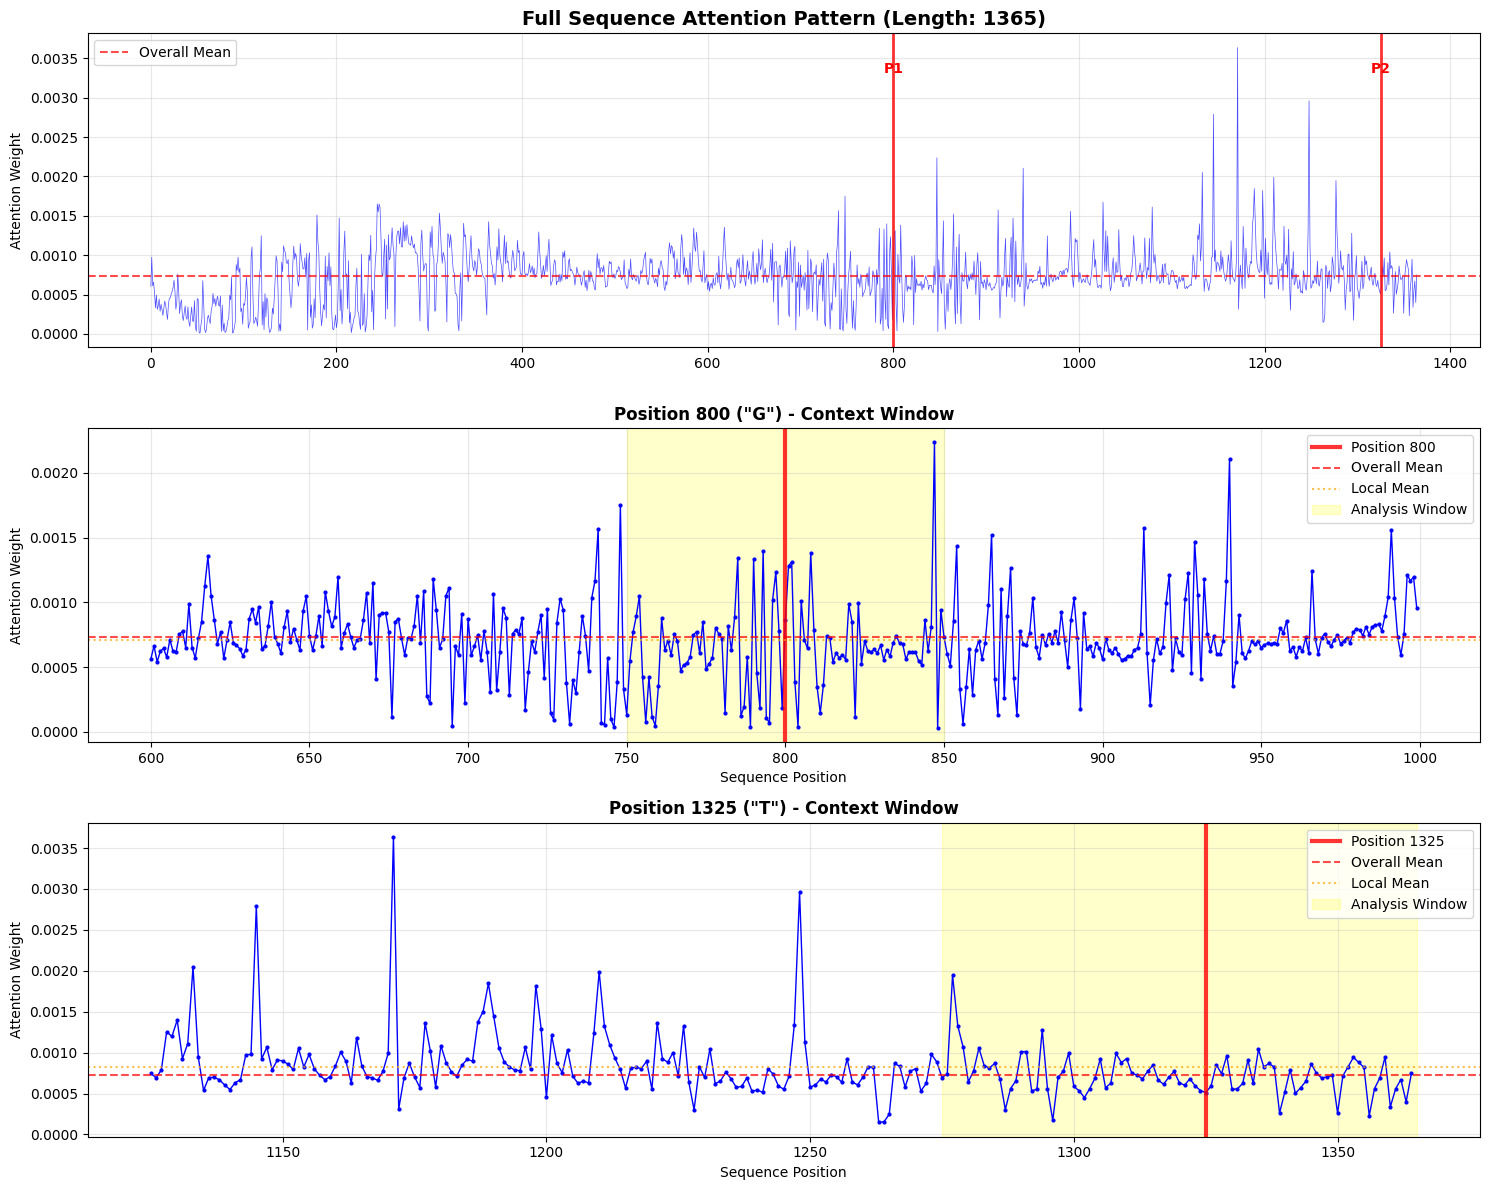


4. SUMMARY OF FINDINGS
Position Analysis Summary:
  Position 800 (G):
    - Attention level: 0.87x the sequence average
    - Z-score: -0.27 (above 0.0% of sequence)
    - ➡️  SIMILAR attention to average
  Position 1325 (T):
    - Attention level: 0.99x the sequence average
    - Z-score: -0.03 (above 0.0% of sequence)
    - ➡️  SIMILAR attention to average

5. TOP ATTENTION POSITIONS FOR COMPARISON
{'Biological': '0.372', 'Chimeric Artifact': '0.628'}
Top 10 attention positions:
 1. Position 1171: 'C' (weight: 0.0036)
 2. Position 1248: 'C' (weight: 0.0030)
 3. Position 1145: 'C' (weight: 0.0028)
 4. Position  847: 'C' (weight: 0.0022)
 5. Position  940: 'C' (weight: 0.0021)
 6. Position 1133: 'C' (weight: 0.0021)
 7. Position 1210: 'C' (weight: 0.0020)
 8. Position 1277: 'G' (weight: 0.0019)
 9. Position 1189: 'G' (weight: 0.0018)
10. Position 1198: 'G' (weight: 0.0018)
ℹ️  None of the biological positions are in the top 10 attention positions
   This suggests they may have average

In [60]:
r1 = next(chimeric_reads)
show_attention_with_biological_pos(r1)

In [ ]:
# Statistical Testing Framework for Position Analysis
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, chi2_contingency
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional

class StatisticalPositionAnalyzer:
    """Statistical analysis of attention patterns at specific positions."""
    
    def __init__(self):
        self.results = {}
        
    def extract_attention_data(self, sequence: str, positions: List[int], 
                             window_size: int = 50) -> Dict:
        """
        Extract attention weights for positions and their windows.
        
        Args:
            sequence: DNA sequence
            positions: List of positions to analyze
            window_size: Size of window around each position
            
        Returns:
            Dictionary with attention data for statistical analysis
        """
        # Get attention weights using existing analyzer
        weights = bio_analyzer.attention_weights(sequence)[1]
        if torch.is_tensor(weights):
            weights = weights.detach().numpy()
        weights = weights[1:]  # Remove CLS token
        
        seq_length = len(sequence)
        weights_length = len(weights)
        min_length = min(seq_length, weights_length)
        
        # Validate positions
        valid_positions = [pos for pos in positions if 0 <= pos < min_length]
        
        # Extract data for each position
        position_data = {}
        for pos in valid_positions:
            # Position-specific attention
            position_attention = weights[pos]
            
            # Window around position
            start = max(0, pos - window_size // 2)
            end = min(min_length, pos + window_size // 2)
            window_attention = weights[start:end]
            
            # Background (rest of sequence excluding window)
            background_mask = np.ones(min_length, dtype=bool)
            background_mask[start:end] = False
            background_attention = weights[background_mask]
            
            position_data[pos] = {
                'position_attention': position_attention,
                'window_attention': window_attention,
                'background_attention': background_attention,
                'window_start': start,
                'window_end': end,
                'nucleotide': sequence[pos]
            }
        
        return {
            'position_data': position_data,
            'all_attention': weights,
            'sequence_length': min_length,
            'window_size': window_size
        }
    
    def test_position_significance(self, attention_data: Dict, 
                                 alpha: float = 0.05) -> Dict:
        """
        Test if positions have significantly different attention from background.
        
        Args:
            attention_data: Output from extract_attention_data
            alpha: Significance level
            
        Returns:
            Dictionary with statistical test results
        """
        results = {}
        
        for pos, data in attention_data['position_data'].items():
            pos_name = f"Position_{pos}"
            results[pos_name] = {}
            
            # Test 1: Position vs Background (one-sample t-test)
            # Compare single position attention to background distribution
            background_mean = np.mean(data['background_attention'])
            background_std = np.std(data['background_attention'])
            
            # Z-score for position attention
            if background_std > 0:
                z_score = (data['position_attention'] - background_mean) / background_std
                p_value_z = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed
            else:
                z_score = 0
                p_value_z = 1.0
            
            results[pos_name]['position_vs_background'] = {
                'test_type': 'z_test',
                'position_attention': data['position_attention'],
                'background_mean': background_mean,
                'background_std': background_std,
                'z_score': z_score,
                'p_value': p_value_z,
                'significant': p_value_z < alpha,
                'effect_size': abs(z_score)  # Effect size as absolute z-score
            }
            
            # Test 2: Window vs Background (two-sample t-test)
            if len(data['window_attention']) > 1:
                # Independent t-test
                t_stat, p_value_t = ttest_ind(
                    data['window_attention'], 
                    data['background_attention'],
                    equal_var=False  # Welch's t-test
                )
                
                # Mann-Whitney U test (non-parametric alternative)
                u_stat, p_value_mw = mannwhitneyu(
                    data['window_attention'], 
                    data['background_attention'],
                    alternative='two-sided'
                )
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(
                    ((len(data['window_attention']) - 1) * np.var(data['window_attention'], ddof=1) +
                     (len(data['background_attention']) - 1) * np.var(data['background_attention'], ddof=1)) /
                    (len(data['window_attention']) + len(data['background_attention']) - 2)
                )
                
                cohens_d = (np.mean(data['window_attention']) - np.mean(data['background_attention'])) / pooled_std if pooled_std > 0 else 0
                
                results[pos_name]['window_vs_background'] = {
                    'test_type': 'two_sample_t_test',
                    'window_mean': np.mean(data['window_attention']),
                    'window_std': np.std(data['window_attention']),
                    'background_mean': np.mean(data['background_attention']),
                    'background_std': np.std(data['background_attention']),
                    't_statistic': t_stat,
                    'p_value_ttest': p_value_t,
                    'u_statistic': u_stat,
                    'p_value_mannwhitney': p_value_mw,
                    'cohens_d': cohens_d,
                    'significant_ttest': p_value_t < alpha,
                    'significant_mannwhitney': p_value_mw < alpha
                }
            else:
                results[pos_name]['window_vs_background'] = {
                    'error': 'Window too small for statistical testing'
                }
        
        return results
    
    def multiple_testing_correction(self, results: Dict, method: str = 'bonferroni') -> Dict:
        """
        Apply multiple testing correction to p-values.
        
        Args:
            results: Output from test_position_significance
            method: Correction method ('bonferroni', 'fdr_bh', 'fdr_by', 'holm')
            
        Returns:
            Results with corrected p-values
        """
        # Collect all p-values
        p_values = []
        test_keys = []
        
        for pos_name, pos_results in results.items():
            if 'position_vs_background' in pos_results:
                p_values.append(pos_results['position_vs_background']['p_value'])
                test_keys.append((pos_name, 'position_vs_background'))
            
            if 'window_vs_background' in pos_results and 'p_value_ttest' in pos_results['window_vs_background']:
                p_values.append(pos_results['window_vs_background']['p_value_ttest'])
                test_keys.append((pos_name, 'window_vs_background_ttest'))
                
                p_values.append(pos_results['window_vs_background']['p_value_mannwhitney'])
                test_keys.append((pos_name, 'window_vs_background_mannwhitney'))
        
        if not p_values:
            return results
        
        # Apply correction
        corrected_p_values = multipletests(p_values, method=method)[1]
        
        # Update results
        for i, (pos_name, test_type) in enumerate(test_keys):
            if test_type == 'position_vs_background':
                results[pos_name]['position_vs_background']['p_value_corrected'] = corrected_p_values[i]
                results[pos_name]['position_vs_background']['significant_corrected'] = corrected_p_values[i] < 0.05
            elif test_type == 'window_vs_background_ttest':
                results[pos_name]['window_vs_background']['p_value_ttest_corrected'] = corrected_p_values[i]
                results[pos_name]['window_vs_background']['significant_ttest_corrected'] = corrected_p_values[i] < 0.05
            elif test_type == 'window_vs_background_mannwhitney':
                results[pos_name]['window_vs_background']['p_value_mannwhitney_corrected'] = corrected_p_values[i]
                results[pos_name]['window_vs_background']['significant_mannwhitney_corrected'] = corrected_p_values[i] < 0.05
        
        return results
    
    def compare_positions(self, attention_data: Dict, alpha: float = 0.05) -> Dict:
        """
        Compare attention between different positions using ANOVA.
        
        Args:
            attention_data: Output from extract_attention_data
            alpha: Significance level
            
        Returns:
            ANOVA results and pairwise comparisons
        """
        # Collect window attention data for all positions
        position_windows = []
        position_labels = []
        
        for pos, data in attention_data['position_data'].items():
            position_windows.append(data['window_attention'])
            position_labels.append(f"Pos_{pos}")
        
        if len(position_windows) < 2:
            return {'error': 'Need at least 2 positions for comparison'}
        
        # One-way ANOVA
        f_stat, p_value_anova = f_oneway(*position_windows)
        
        # Calculate effect size (eta-squared)
        all_windows = np.concatenate(position_windows)
        grand_mean = np.mean(all_windows)
        
        ss_between = sum(len(window) * (np.mean(window) - grand_mean)**2 for window in position_windows)
        ss_total = np.sum((all_windows - grand_mean)**2)
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        # Pairwise comparisons (t-tests)
        pairwise_results = {}
        n_comparisons = len(position_labels) * (len(position_labels) - 1) // 2
        
        for i in range(len(position_labels)):
            for j in range(i + 1, len(position_labels)):
                pos_i, pos_j = position_labels[i], position_labels[j]
                window_i, window_j = position_windows[i], position_windows[j]
                
                t_stat, p_value = ttest_ind(window_i, window_j, equal_var=False)
                
                # Bonferroni correction for pairwise comparisons
                p_value_corrected = min(p_value * n_comparisons, 1.0)
                
                pairwise_results[f"{pos_i}_vs_{pos_j}"] = {
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'p_value_corrected': p_value_corrected,
                    'significant': p_value_corrected < alpha,
                    'mean_diff': np.mean(window_i) - np.mean(window_j)
                }
        
        return {
            'anova': {
                'f_statistic': f_stat,
                'p_value': p_value_anova,
                'eta_squared': eta_squared,
                'significant': p_value_anova < alpha
            },
            'pairwise_comparisons': pairwise_results,
            'n_positions': len(position_labels),
            'n_comparisons': n_comparisons
        }
    
    def generate_report(self, results: Dict, comparison_results: Dict = None) -> str:
        """
        Generate a comprehensive statistical report.
        
        Args:
            results: Output from test_position_significance (with corrections)
            comparison_results: Output from compare_positions
            
        Returns:
            Formatted report string
        """
        report = []
        report.append("=" * 80)
        report.append("STATISTICAL ANALYSIS REPORT")
        report.append("=" * 80)
        
        # Individual position tests
        report.append("\n1. POSITION SIGNIFICANCE TESTS")
        report.append("-" * 50)
        
        significant_positions = []
        
        for pos_name, pos_results in results.items():
            pos_num = pos_name.split('_')[1]
            nucleotide = pos_results.get('nucleotide', 'Unknown')
            
            report.append(f"\nPosition {pos_num} ({nucleotide}):")
            
            # Position vs background
            if 'position_vs_background' in pos_results:
                pos_test = pos_results['position_vs_background']
                report.append(f"  Position vs Background (Z-test):")
                report.append(f"    - Position attention: {pos_test['position_attention']:.4f}")
                report.append(f"    - Background mean: {pos_test['background_mean']:.4f} ± {pos_test['background_std']:.4f}")
                report.append(f"    - Z-score: {pos_test['z_score']:.2f}")
                report.append(f"    - P-value: {pos_test['p_value']:.4f}")
                if 'p_value_corrected' in pos_test:
                    report.append(f"    - P-value (corrected): {pos_test['p_value_corrected']:.4f}")
                    significant = pos_test['significant_corrected']
                else:
                    significant = pos_test['significant']
                report.append(f"    - Significant: {'Yes' if significant else 'No'}")
                
                if significant:
                    significant_positions.append(pos_num)
            
            # Window vs background
            if 'window_vs_background' in pos_results and 'error' not in pos_results['window_vs_background']:
                window_test = pos_results['window_vs_background']
                report.append(f"  Window vs Background:")
                report.append(f"    - Window mean: {window_test['window_mean']:.4f} ± {window_test['window_std']:.4f}")
                report.append(f"    - Background mean: {window_test['background_mean']:.4f} ± {window_test['background_std']:.4f}")
                report.append(f"    - Cohen's d: {window_test['cohens_d']:.2f}")
                
                # T-test results
                report.append(f"    - T-test p-value: {window_test['p_value_ttest']:.4f}")
                if 'p_value_ttest_corrected' in window_test:
                    report.append(f"    - T-test p-value (corrected): {window_test['p_value_ttest_corrected']:.4f}")
                    ttest_sig = window_test['significant_ttest_corrected']
                else:
                    ttest_sig = window_test['significant_ttest']
                report.append(f"    - T-test significant: {'Yes' if ttest_sig else 'No'}")
                
                # Mann-Whitney results
                report.append(f"    - Mann-Whitney p-value: {window_test['p_value_mannwhitney']:.4f}")
                if 'p_value_mannwhitney_corrected' in window_test:
                    report.append(f"    - Mann-Whitney p-value (corrected): {window_test['p_value_mannwhitney_corrected']:.4f}")
                    mw_sig = window_test['significant_mannwhitney_corrected']
                else:
                    mw_sig = window_test['significant_mannwhitney']
                report.append(f"    - Mann-Whitney significant: {'Yes' if mw_sig else 'No'}")
        
        # Summary
        report.append(f"\nSUMMARY:")
        report.append(f"  - Total positions tested: {len(results)}")
        report.append(f"  - Significantly different positions: {len(significant_positions)}")
        if significant_positions:
            report.append(f"  - Significant positions: {', '.join(significant_positions)}")
        
        # Position comparisons
        if comparison_results and 'error' not in comparison_results:
            report.append("\n2. POSITION COMPARISONS")
            report.append("-" * 50)
            
            anova = comparison_results['anova']
            report.append(f"ANOVA Results:")
            report.append(f"  - F-statistic: {anova['f_statistic']:.2f}")
            report.append(f"  - P-value: {anova['p_value']:.4f}")
            report.append(f"  - Effect size (η²): {anova['eta_squared']:.3f}")
            report.append(f"  - Significant differences: {'Yes' if anova['significant'] else 'No'}")
            
            if anova['significant']:
                report.append(f"\nPairwise Comparisons (Bonferroni corrected):")
                for comparison, result in comparison_results['pairwise_comparisons'].items():
                    status = "Significant" if result['significant'] else "Not significant"
                    report.append(f"  - {comparison}: {status} (p={result['p_value_corrected']:.4f}, diff={result['mean_diff']:.4f})")
        
        return "\n".join(report)

# Create statistical analyzer instance
stat_analyzer = StatisticalPositionAnalyzer()


In [ ]:
# Statistical Visualization Methods
class StatisticalVisualizer:
    """Visualization methods for statistical analysis results."""
    
    def plot_position_comparison(self, attention_data: Dict, results: Dict, 
                                figsize: Tuple[int, int] = (15, 10)) -> None:
        """
        Create comprehensive visualization of position analysis results.
        
        Args:
            attention_data: Output from extract_attention_data
            results: Output from test_position_significance
            figsize: Figure size tuple
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        n_positions = len(attention_data['position_data'])
        
        fig, axes = plt.subplots(3, 2, figsize=figsize)
        fig.suptitle('Statistical Analysis of Position Attention Patterns', fontsize=16, fontweight='bold')
        
        # 1. Overall attention pattern with positions marked
        ax1 = axes[0, 0]
        all_attention = attention_data['all_attention']
        ax1.plot(range(len(all_attention)), all_attention, 'b-', alpha=0.7, linewidth=0.8)
        ax1.axhline(y=np.mean(all_attention), color='r', linestyle='--', alpha=0.7, label='Overall Mean')
        
        # Mark positions of interest
        colors = plt.cm.Set1(np.linspace(0, 1, n_positions))
        for i, (pos, data) in enumerate(attention_data['position_data'].items()):
            ax1.axvline(x=pos, color=colors[i], linestyle='-', linewidth=2, alpha=0.8)
            ax1.text(pos, np.max(all_attention) * 0.9, f'P{pos}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color=colors[i])
        
        ax1.set_title('Full Sequence with Marked Positions')
        ax1.set_xlabel('Position')
        ax1.set_ylabel('Attention Weight')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Box plots comparing positions
        ax2 = axes[0, 1]
        position_data_for_box = []
        position_labels = []
        
        for pos, data in attention_data['position_data'].items():
            position_data_for_box.append(data['window_attention'])
            position_labels.append(f'Pos {pos}')
        
        bp = ax2.boxplot(position_data_for_box, labels=position_labels, patch_artist=True)
        ax2.axhline(y=np.mean(all_attention), color='r', linestyle='--', alpha=0.7, label='Overall Mean')
        
        # Color boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax2.set_title('Attention Distribution by Position')
        ax2.set_ylabel('Attention Weight')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Z-scores for each position
        ax3 = axes[1, 0]
        positions = []
        z_scores = []
        p_values = []
        
        for pos_name, pos_results in results.items():
            if 'position_vs_background' in pos_results:
                pos_num = int(pos_name.split('_')[1])
                positions.append(pos_num)
                z_scores.append(pos_results['position_vs_background']['z_score'])
                p_values.append(pos_results['position_vs_background']['p_value'])
        
        bars = ax3.bar(positions, z_scores, color=colors[:len(positions)], alpha=0.7)
        ax3.axhline(y=1.96, color='r', linestyle='--', alpha=0.7, label='Significance threshold (±1.96)')
        ax3.axhline(y=-1.96, color='r', linestyle='--', alpha=0.7)
        ax3.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        
        # Add significance indicators
        for i, (bar, p_val) in enumerate(zip(bars, p_values)):
            height = bar.get_height()
            significance = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
            ax3.text(bar.get_x() + bar.get_width()/2, height + (0.1 if height >= 0 else -0.1), 
                    significance, ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')
        
        ax3.set_title('Z-scores for Position vs Background')
        ax3.set_xlabel('Position')
        ax3.set_ylabel('Z-score')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. P-values (log scale)
        ax4 = axes[1, 1]
        p_values_log = [-np.log10(p) for p in p_values]
        bars = ax4.bar(positions, p_values_log, color=colors[:len(positions)], alpha=0.7)
        ax4.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.7, label='α = 0.05')
        ax4.axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='α = 0.01')
        
        ax4.set_title('P-values (log scale)')
        ax4.set_xlabel('Position')
        ax4.set_ylabel('-log₁₀(p-value)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Effect sizes (Cohen's d)
        ax5 = axes[2, 0]
        effect_sizes = []
        
        for pos_name, pos_results in results.items():
            if 'window_vs_background' in pos_results and 'cohens_d' in pos_results['window_vs_background']:
                effect_sizes.append(pos_results['window_vs_background']['cohens_d'])
            else:
                effect_sizes.append(0)
        
        bars = ax5.bar(positions, effect_sizes, color=colors[:len(positions)], alpha=0.7)
        ax5.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Small effect (0.2)')
        ax5.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Medium effect (0.5)')
        ax5.axhline(y=0.8, color='darkred', linestyle='--', alpha=0.7, label='Large effect (0.8)')
        ax5.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        
        ax5.set_title("Effect Sizes (Cohen's d)")
        ax5.set_xlabel('Position')
        ax5.set_ylabel("Cohen's d")
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Summary statistics table
        ax6 = axes[2, 1]
        ax6.axis('off')
        
        # Create summary table
        table_data = []
        for i, pos in enumerate(positions):
            pos_name = f"Position_{pos}"
            if pos_name in results:
                pos_results = results[pos_name]
                if 'position_vs_background' in pos_results:
                    z_score = pos_results['position_vs_background']['z_score']
                    p_val = pos_results['position_vs_background']['p_value']
                    significant = 'Yes' if p_val < 0.05 else 'No'
                    
                    if 'window_vs_background' in pos_results and 'cohens_d' in pos_results['window_vs_background']:
                        cohens_d = pos_results['window_vs_background']['cohens_d']
                    else:
                        cohens_d = 'N/A'
                    
                    table_data.append([f'Pos {pos}', f'{z_score:.2f}', f'{p_val:.4f}', significant, f'{cohens_d:.2f}' if cohens_d != 'N/A' else 'N/A'])
        
        table = ax6.table(cellText=table_data,
                         colLabels=['Position', 'Z-score', 'P-value', 'Significant', "Cohen's d"],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        ax6.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
    
    def plot_attention_distributions(self, attention_data: Dict, results: Dict) -> None:
        """Plot detailed attention distributions for each position."""
        import matplotlib.pyplot as plt
        
        n_positions = len(attention_data['position_data'])
        fig, axes = plt.subplots(2, (n_positions + 1) // 2, figsize=(5 * ((n_positions + 1) // 2), 10))
        if n_positions == 1:
            axes = [axes]
        elif n_positions == 2:
            axes = axes
        else:
            axes = axes.flatten()
        
        colors = plt.cm.Set1(np.linspace(0, 1, n_positions))
        
        for i, (pos, data) in enumerate(attention_data['position_data'].items()):
            ax = axes[i] if n_positions > 1 else axes[0]
            
            # Plot distributions
            ax.hist(data['background_attention'], bins=50, alpha=0.5, color='lightblue', 
                   label='Background', density=True)
            ax.hist(data['window_attention'], bins=30, alpha=0.7, color=colors[i], 
                   label=f'Window (Pos {pos})', density=True)
            
            # Mark position attention
            ax.axvline(data['position_attention'], color='red', linestyle='-', linewidth=3, 
                      label=f'Position {pos}', alpha=0.8)
            
            # Mark means
            ax.axvline(np.mean(data['background_attention']), color='blue', linestyle='--', 
                      label='Background mean', alpha=0.7)
            ax.axvline(np.mean(data['window_attention']), color=colors[i], linestyle='--', 
                      label='Window mean', alpha=0.7)
            
            # Add statistics
            pos_name = f"Position_{pos}"
            if pos_name in results and 'window_vs_background' in results[pos_name]:
                test_results = results[pos_name]['window_vs_background']
                if 'p_value_ttest' in test_results:
                    p_val = test_results['p_value_ttest']
                    cohens_d = test_results.get('cohens_d', 0)
                    ax.text(0.02, 0.98, f'p = {p_val:.4f}\nCohen\'s d = {cohens_d:.2f}', 
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_title(f'Position {pos} Attention Distribution')
            ax.set_xlabel('Attention Weight')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        if n_positions < len(axes):
            for j in range(n_positions, len(axes)):
                axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def plot_anova_results(self, attention_data: Dict, comparison_results: Dict) -> None:
        """Plot ANOVA and pairwise comparison results."""
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. ANOVA effect size
        ax1 = axes[0]
        anova = comparison_results['anova']
        eta_squared = anova['eta_squared']
        
        bars = ax1.bar(['ANOVA'], [eta_squared], color='steelblue', alpha=0.7)
        ax1.axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, label='Small (0.01)')
        ax1.axhline(y=0.06, color='r', linestyle='--', alpha=0.7, label='Medium (0.06)')
        ax1.axhline(y=0.14, color='darkred', linestyle='--', alpha=0.7, label='Large (0.14)')
        
        ax1.set_title(f'ANOVA Effect Size (η² = {eta_squared:.3f})')
        ax1.set_ylabel("Effect Size (η²)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Pairwise comparison p-values
        ax2 = axes[1]
        comparisons = list(comparison_results['pairwise_comparisons'].keys())
        p_values = [comparison_results['pairwise_comparisons'][comp]['p_value'] for comp in comparisons]
        p_values_corrected = [comparison_results['pairwise_comparisons'][comp]['p_value_corrected'] for comp in comparisons]
        
        x = np.arange(len(comparisons))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, p_values, width, label='Original p-values', alpha=0.7, color='lightblue')
        bars2 = ax2.bar(x + width/2, p_values_corrected, width, label='Bonferroni corrected', alpha=0.7, color='orange')
        
        ax2.axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='α = 0.05')
        ax2.set_title('Pairwise Comparison P-values')
        ax2.set_xlabel('Comparisons')
        ax2.set_ylabel('P-value')
        ax2.set_xticks(x)
        ax2.set_xticklabels([comp.replace('_vs_', ' vs ') for comp in comparisons], rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Mean differences
        ax3 = axes[2]
        mean_diffs = [comparison_results['pairwise_comparisons'][comp]['mean_diff'] for comp in comparisons]
        colors = ['green' if diff > 0 else 'red' for diff in mean_diffs]
        
        bars = ax3.bar(comparisons, mean_diffs, color=colors, alpha=0.7)
        ax3.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        ax3.set_title('Mean Differences (Window Attention)')
        ax3.set_xlabel('Comparisons')
        ax3.set_ylabel('Mean Difference')
        ax3.set_xticklabels([comp.replace('_vs_', ' vs ') for comp in comparisons], rotation=45)
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Create visualization instance
stat_visualizer = StatisticalVisualizer()


In [ ]:
# Complete Statistical Analysis Integration
def comprehensive_statistical_analysis(sequence: str, positions: List[int], 
                                     window_size: int = 50, alpha: float = 0.05,
                                     correction_method: str = 'bonferroni',
                                     show_plots: bool = True) -> Dict:
    """
    Perform comprehensive statistical analysis of position attention patterns.
    
    Args:
        sequence: DNA sequence to analyze
        positions: List of positions to test
        window_size: Size of window around each position
        alpha: Significance level
        correction_method: Method for multiple testing correction
        show_plots: Whether to display visualization plots
        
    Returns:
        Dictionary containing all analysis results
    """
    print("=" * 80)
    print("COMPREHENSIVE STATISTICAL ANALYSIS")
    print("=" * 80)
    print(f"Sequence length: {len(sequence)}")
    print(f"Positions to analyze: {positions}")
    print(f"Window size: {window_size}")
    print(f"Significance level: {alpha}")
    print(f"Correction method: {correction_method}")
    
    # Step 1: Extract attention data
    print("\n1. Extracting attention data...")
    attention_data = stat_analyzer.extract_attention_data(sequence, positions, window_size)
    
    # Step 2: Test position significance
    print("2. Testing position significance...")
    results = stat_analyzer.test_position_significance(attention_data, alpha)
    
    # Step 3: Apply multiple testing correction
    print(f"3. Applying {correction_method} correction...")
    results_corrected = stat_analyzer.multiple_testing_correction(results, correction_method)
    
    # Step 4: Compare positions (if more than one)
    comparison_results = None
    if len(positions) > 1:
        print("4. Comparing positions with ANOVA...")
        comparison_results = stat_analyzer.compare_positions(attention_data, alpha)
    else:
        print("4. Skipping position comparison (need at least 2 positions)")
    
    # Step 5: Generate report
    print("5. Generating statistical report...")
    report = stat_analyzer.generate_report(results_corrected, comparison_results)
    print(report)
    
    # Step 6: Create visualizations
    if show_plots:
        print("\n6. Creating visualizations...")
        
        # Main comparison plot
        stat_visualizer.plot_position_comparison(attention_data, results_corrected)
        
        # Detailed distribution plots
        stat_visualizer.plot_attention_distributions(attention_data, results_corrected)
        
        # ANOVA results (if available)
        if comparison_results and 'error' not in comparison_results:
            stat_visualizer.plot_anova_results(attention_data, comparison_results)
    
    # Return comprehensive results
    return {
        'attention_data': attention_data,
        'results_uncorrected': results,
        'results_corrected': results_corrected,
        'comparison_results': comparison_results,
        'report': report,
        'parameters': {
            'sequence_length': len(sequence),
            'positions': positions,
            'window_size': window_size,
            'alpha': alpha,
            'correction_method': correction_method
        }
    }

# Test with the current read data
def test_statistical_analysis_with_current_read():
    """Test the statistical analysis with the current chimeric read."""
    try:
        # Get the current read data
        read_name, test_sequence, biological_positions = get_sequence_and_pos(r1)
        
        print(f"Testing with read: {read_name}")
        print(f"Sequence length: {len(test_sequence)}")
        print(f"Biological positions: {biological_positions}")
        print(f"Sequence preview: {test_sequence[:100]}...")
        
        # Perform comprehensive analysis
        results = comprehensive_statistical_analysis(
            sequence=test_sequence,
            positions=biological_positions,
            window_size=100,  # ±50 nucleotides around each position
            alpha=0.05,
            correction_method='bonferroni',
            show_plots=True
        )
        
        return results
        
    except Exception as e:
        print(f"Error in statistical analysis: {e}")
        print("This might be due to model limitations or data issues.")
        return None

# Run the test
print("Testing comprehensive statistical analysis...")
statistical_results = test_statistical_analysis_with_current_read()


In [ ]:
# Multi-read Statistical Analysis
def analyze_multiple_reads(num_reads: int = 10, window_size: int = 50, 
                          alpha: float = 0.05, correction_method: str = 'fdr_bh') -> Dict:
    """
    Analyze attention patterns across multiple chimeric reads.
    
    Args:
        num_reads: Number of reads to analyze
        window_size: Window size for position analysis
        alpha: Significance level
        correction_method: Multiple testing correction method
        
    Returns:
        Aggregated results across all reads
    """
    print("=" * 80)
    print("MULTI-READ STATISTICAL ANALYSIS")
    print("=" * 80)
    
    all_results = []
    all_attention_data = []
    read_info = []
    
    # Reset the chimeric reads iterator
    chimeric_reads = chimeric_read_iterator(bam_file)
    
    for i in range(num_reads):
        try:
            print(f"\nAnalyzing read {i+1}/{num_reads}...")
            
            # Get next chimeric read
            read = next(chimeric_reads)
            read_name, sequence, positions = get_sequence_and_pos(read)
            
            print(f"  Read: {read_name}")
            print(f"  Sequence length: {len(sequence)}")
            print(f"  Positions: {positions}")
            
            # Extract attention data
            attention_data = stat_analyzer.extract_attention_data(sequence, positions, window_size)
            
            # Test significance
            results = stat_analyzer.test_position_significance(attention_data, alpha)
            
            # Apply correction
            results_corrected = stat_analyzer.multiple_testing_correction(results, correction_method)
            
            # Store results
            all_results.append(results_corrected)
            all_attention_data.append(attention_data)
            read_info.append({
                'read_name': read_name,
                'sequence_length': len(sequence),
                'positions': positions
            })
            
            print(f"  Analysis completed for {read_name}")
            
        except StopIteration:
            print(f"  No more chimeric reads available after {i} reads")
            break
        except Exception as e:
            print(f"  Error analyzing read {i+1}: {e}")
            continue
    
    if not all_results:
        print("No reads could be analyzed successfully.")
        return {'error': 'No successful analyses'}
    
    # Aggregate results across reads
    print(f"\nAggregating results across {len(all_results)} reads...")
    
    # Collect all significant positions
    significant_positions_per_read = []
    all_p_values = []
    all_effect_sizes = []
    
    for i, (results, read_data) in enumerate(zip(all_results, read_info)):
        read_significant = []
        
        for pos_name, pos_results in results.items():
            if 'position_vs_background' in pos_results:
                pos_num = int(pos_name.split('_')[1])
                p_val = pos_results['position_vs_background']['p_value']
                z_score = pos_results['position_vs_background']['z_score']
                
                all_p_values.append(p_val)
                all_effect_sizes.append(abs(z_score))
                
                if 'significant_corrected' in pos_results['position_vs_background']:
                    significant = pos_results['position_vs_background']['significant_corrected']
                else:
                    significant = pos_results['position_vs_background']['significant']
                
                if significant:
                    read_significant.append(pos_num)
        
        significant_positions_per_read.append(read_significant)
    
    # Summary statistics
    total_positions_tested = sum(len(read_data['positions']) for read_data in read_info)
    total_significant = sum(len(sig_pos) for sig_pos in significant_positions_per_read)
    
    print(f"\nSUMMARY ACROSS ALL READS:")
    print(f"  Total reads analyzed: {len(all_results)}")
    print(f"  Total positions tested: {total_positions_tested}")
    print(f"  Total significant positions: {total_significant}")
    print(f"  Percentage significant: {(total_significant/total_positions_tested)*100:.1f}%")
    
    # P-value distribution
    print(f"\nP-value statistics:")
    print(f"  Mean p-value: {np.mean(all_p_values):.4f}")
    print(f"  Median p-value: {np.median(all_p_values):.4f}")
    print(f"  Min p-value: {np.min(all_p_values):.4f}")
    print(f"  Max p-value: {np.max(all_p_values):.4f}")
    print(f"  P-values < 0.05: {sum(1 for p in all_p_values if p < 0.05)} / {len(all_p_values)} ({(sum(1 for p in all_p_values if p < 0.05)/len(all_p_values))*100:.1f}%)")
    
    # Effect size statistics
    print(f"\nEffect size statistics:")
    print(f"  Mean effect size: {np.mean(all_effect_sizes):.4f}")
    print(f"  Median effect size: {np.median(all_effect_sizes):.4f}")
    print(f"  Min effect size: {np.min(all_effect_sizes):.4f}")
    print(f"  Max effect size: {np.max(all_effect_sizes):.4f}")
    print(f"  Large effects (|z| > 1.96): {sum(1 for es in all_effect_sizes if es > 1.96)} / {len(all_effect_sizes)} ({(sum(1 for es in all_effect_sizes if es > 1.96)/len(all_effect_sizes))*100:.1f}%)")
    
    # Position frequency analysis
    all_positions = []
    for read_data in read_info:
        all_positions.extend(read_data['positions'])
    
    position_counts = {}
    for pos in all_positions:
        position_counts[pos] = position_counts.get(pos, 0) + 1
    
    print(f"\nPosition frequency analysis:")
    print(f"  Most common positions: {sorted(position_counts.items(), key=lambda x: x[1], reverse=True)[:5]}")
    
    return {
        'all_results': all_results,
        'all_attention_data': all_attention_data,
        'read_info': read_info,
        'significant_positions_per_read': significant_positions_per_read,
        'summary_stats': {
            'total_reads': len(all_results),
            'total_positions_tested': total_positions_tested,
            'total_significant': total_significant,
            'percentage_significant': (total_significant/total_positions_tested)*100,
            'mean_p_value': np.mean(all_p_values),
            'median_p_value': np.median(all_p_values),
            'mean_effect_size': np.mean(all_effect_sizes),
            'median_effect_size': np.median(all_effect_sizes)
        },
        'p_values': all_p_values,
        'effect_sizes': all_effect_sizes,
        'position_counts': position_counts
    }

# Test with multiple reads
print("\n" + "="*80)
print("TESTING MULTI-READ ANALYSIS")
print("="*80)

# Analyze 5 reads for demonstration (you can increase this number)
multi_read_results = analyze_multiple_reads(num_reads=5, window_size=100, alpha=0.05, correction_method='fdr_bh')
